# Tutorial 4 - Assessing cartilage features and pathology from hyperspectral data

Original author: [Santeri Rytky](https://www.oulu.fi/fi/tutkijat/santeri-rytky)

In this tutorial, you will learn to run machine learning experiments on hyperspectral data. In the case of spectroscopy imaging, each image pixel includes a spectrum that is measured from multiple frequencies (wavenumber).

The dataset consists of bone-cartilage samples imaged with a Raman spectroscope. The imaged regions include the bone-cartilage interface, an area connecting articular cartilage to the underlying subchondral bone. The samples include different stages of osteoarthritis, a common joint disease. Details of the grading scheme are described in the study by [Pritzker et al.](https://doi.org/10.1016/j.joca.2005.07.014).

The measurements are collected in MIPT, University of Oulu. The spectral data is already preprocessed, including spectral truncation, filtering, baseline correction and vector normalization.

Topics covered:
- Conventional analysis for spectroscopy data
- Predicting ordinal/linear variables
- Reducing feature dimensionality
- Adding polynomial features
- Detecting tissue types without labels (unsupervised learning)

In [ ]:
'''
# Mount the Google drive folder to Colab
from google.colab import drive
drive.mount('/content/drive')

import sys
path = '/content/drive/My Drive/MLinMedicine/Tutorial4/'
sys.path.append(path)
''';

In [ ]:
# Extract the data folder (quietly). If you have already extracted, select N
#!unzip -q '/content/drive/My Drive/MLinMedicine/Tutorial4/Raman_data.zip' -d '/content/drive/My Drive/MLinMedicine/Tutorial4/Raman_data'

<font size="5">Note that you need to unzip the "Raman_data.zip" manually if you are using windows. The unzip command should work on linux.</font>

In [19]:
!pip install "numpy<2"
!pip install  h5py

In [1]:
# Interactions with the operating system
import os

# Timing and dates
import time

# Load .mat files
import h5py

# Run mathematical operations
import numpy as np

# Generate informative plots
import matplotlib.pyplot as plt

# Scikit-learn is a package with multiple machine learning tools

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# Data splitting
from sklearn.model_selection import train_test_split
# Ridge regression model
from sklearn.linear_model import Ridge, LinearRegression, Lasso
# Pipeline
from sklearn.pipeline import Pipeline
# Unsupervised learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
# Metrics
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

# 1. Load data and preprocess

The Raman measurements are stored in .mat files (commonly used in Matlab). The `h5py` library is compatible with the data type, and we can use similar functions as previously for loading. Note that the **disease severity** (grade, G) and a sample index (S) are specified in the filename. The dataset includes measurements from a total of 10 patients, two from each grade. A higher grade means a more progressed disease stage.

In [8]:
# Base path
path = './Raman_data/'

# List samples
samples = os.listdir(path)
samples.sort()
print(samples)

# Load the Raman measurements and wavenumber axis
data, wavenumber = [], []
for sample in samples:
    with h5py.File(path + sample, 'r') as f:
        data.append(f['data'][:])
        wavenumber.append(f['wavenumber'][:].squeeze())  # Remove extra dimension

print(f'\nThe dataset has measurements from {len(data)} samples.')
print('Example shape: ', data[0].shape)

['G0_S1.mat', 'G0_S2.mat', 'G1_S1.mat', 'G1_S2.mat', 'G2_S1.mat', 'G2_S2.mat', 'G3_S1.mat', 'G3_S2.mat', 'G4_S1.mat', 'G4_S2.mat']

The dataset has measurements from 10 samples.
Example shape:  (727, 60, 340)


The data array is in format: **(wavenumber, x, y)**, including one spectral and two spatial dimensions.

The Raman signal is acquired by measuring inelastic scattering of light (laser) from the sample. Since laser light with a narrow wavenumber (wavelength) band is used, the original wavenumber is filtered out and the Raman scattered wavenumbers remain. The change in wavenumber, **Raman shift**, is plotted on the x-axis of the spectrum. The measurement is repeated in small spots with a grid shape (**x and y dimension**), allowing Raman imaging. 

The Raman shift occurs due to interaction with specific chemical constituents of the sample. This means that each spectrum yields a **"chemical fingerprint"** of the sample. Let's take a look at two examples of a Raman spectrum.

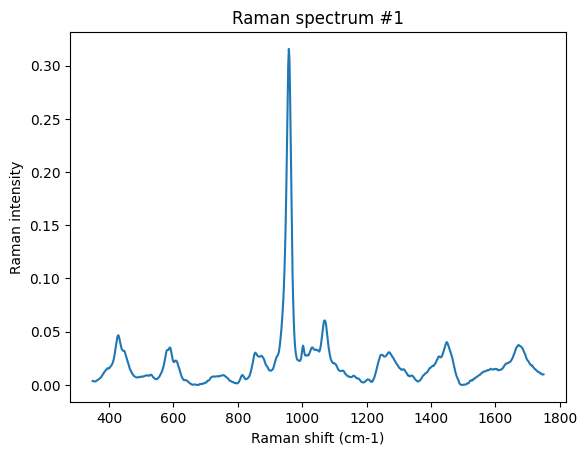

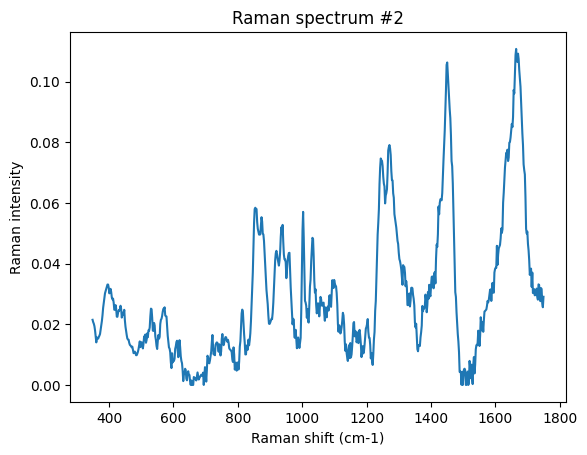

In [9]:
# Plot a measurement from the middle of the sample
plt.plot(wavenumber[0], data[0][:, 30, 170])
plt.ylabel('Raman intensity')
plt.xlabel('Raman shift (cm-1)')
plt.title('Raman spectrum #1')
plt.show()

# Plot a measurement from the end of the sample
plt.plot(wavenumber[0], data[0][:, 0, -1])  # -1 denotes the final element
plt.ylabel('Raman intensity')
plt.xlabel('Raman shift (cm-1)')
plt.title('Raman spectrum #2')
plt.show()

In the Raman spectrum, there are multiple **peaks** visible. The peaks correspond to specific vibrational and rotational states of molecular bonds. This phenomenon allows to obtain relative quantities of the chemical constituents of the sample. For example, in the bone-cartilage interface, there are specific peaks for collagen, glycosaminoglycans (proteoglycan) and phosphate (mineral) components of the tissue. 

In the top figure, the large peak at ~960cm-1 relates to the phosphate content of the sample. Bone and cartilage specific spectra are explained below (source: [Buchwald et al 2012](https://doi.org/10.1117/1.JBO.17.1.017007)).

![./Raman_bone_peaks.png](./Raman_bone_peaks.png)
![./Raman_bone_peaks.png](./Raman_bone_peaks.png)

Next, we can create the training, validation and test **splits**. Since the dataset is quite limited, we can save one sample from each grade for testing, and split the rest in training and validation folds.

During training and validation split, we will **stratify** the splits so that the grades keep the same distribution as before splitting. However, we need to mix the patients to include all grades in training and validation (this should always be avoided when possible).

In [12]:
# Create dataset for regression

X_train, Y_train = [], []
X_test, Y_test = [], []

# Loop for all 10 samples
for id in range(len(data)):

    # Every second sample for training and testing
    if id % 2:  # % is used to denote modulus (remainder of the division)
        # X and Y dimensions are combined
        X_train.append(data[id].reshape(data[id].shape[0], -1))
        # Grades 0-4
        Y_train.extend(np.repeat(id // 2, data[id].shape[1] * data[id].shape[2]))
    else:
        X_test.append(data[id].reshape(data[id].shape[0], -1))
        Y_test.extend(np.repeat(id // 2, data[id].shape[1] * data[id].shape[2]))

# Combine samples
X_train = np.column_stack(X_train)
Y_train = np.array(Y_train)
X_test = np.column_stack(X_test)
Y_test = np.array(Y_test)

# Move wavenumber axis as last
X_train = X_train.transpose(1, 0)
X_test = X_test.transpose(1, 0)

# Train, validation and test split (accounting for samples)
seed = 4
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.33, random_state=seed, 
                                                  shuffle=True, stratify=Y_train)
# Display dataset details
print('Train\nData shape: ', X_train.shape)
print('Grades included: ', np.unique(Y_train))
print('\nValidation\nData shape: ', X_val.shape)
print('Grades included: ', np.unique(Y_val))
print('\nTest\nData shape: ', X_test.shape)
print('Grades included: ', np.unique(Y_test))

Train
Data shape:  (53466, 727)
Grades included:  [0 1 2 3 4]

Validation
Data shape:  (26334, 727)
Grades included:  [0 1 2 3 4]

Test
Data shape:  (94800, 727)
Grades included:  [0 1 2 3 4]


As shown above, the data is now arranged so that each measurement point in the Raman map is considered one sample and the wavenumber axis includes the **spectral features** for each sample.

# 2. Baseline analysis

The basic spectroscopy analysis includes **univariate (single variable) analysis**. In this case, often the spectroscopy map is plotted to show the distribution of different chemical constituents of the sample.

For example, we can visualize distribution of a single wavenumber, a wavenumber range, or average intensity of the full spectral range. 

As an example, we will visualize the mineral peak (wavenumber 960cm-1), amide I region (1595-1700cm-1), and the mean spectrum. To get the corresponding wavenumbers, we can create a simple function that, when given a wavenumber, returns the closest measurement from the spectrum.

You can try changing the ID to visualize different samples (0-9). Low IDs show more healthy tissue, while higher IDs correspond to the late-stage osteoarthritis patients.

In [13]:
def find_nearest_idx(vector, wavenumber):
    """Finds the closest index corresponding to the given wavenumber."""
    if isinstance(wavenumber, list):
        idx = []
        for i in range(len(wavenumber)):
            idx.append((np.abs(vector - wavenumber[i])).argmin())
    else:
        idx = (np.abs(vector - wavenumber)).argmin()
    return idx

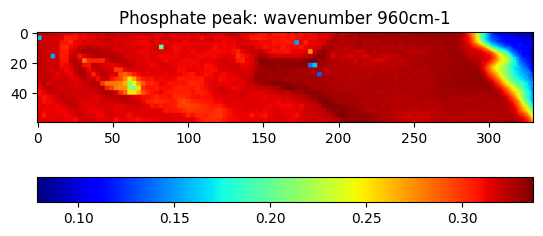

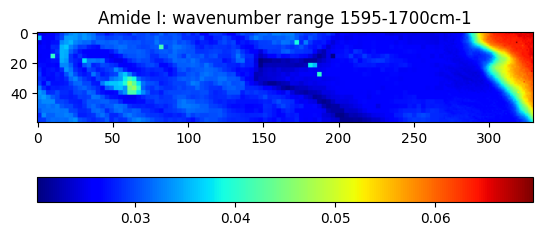

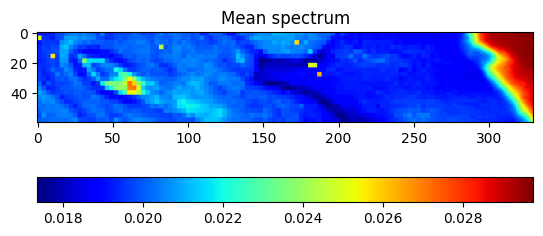

In [14]:
# Phosphate peak (960cm-1)
wn = 960
ID = 9
# Plot specific wavenumber
plt.imshow(data[ID][find_nearest_idx(wavenumber[0], wn), :, :], cmap='jet')
plt.title(f'Phosphate peak: wavenumber {wn}cm-1')
plt.colorbar(orientation='horizontal')
plt.show()

# Plot a wavenumber range (Amide I, 1595-1700cm-1)
wn_range = [1595, 1700]
wn_range_idx = find_nearest_idx(wavenumber[0], wn_range)
window_image = np.mean(data[ID][wn_range_idx[0]:wn_range_idx[1], :, :], axis=0)

plt.imshow(window_image, cmap='jet')
plt.title(f'Amide I: wavenumber range {wn_range[0]}-{wn_range[1]}cm-1')
plt.colorbar(orientation='horizontal')
plt.show()

# Plot the mean spectrum
plt.imshow(np.mean(data[ID], axis=0), cmap='jet')
plt.title(f'Mean spectrum')
plt.colorbar(orientation='horizontal')
plt.show()

With univariate analysis, it is possible to highlight the regions that absorb the specific wavenumber range. 

# 3. Regression

Next, we will try to assess osteoarthritis severity from the samples (OARSI grade). The severity is assessed manually by a trained professional, aiming to find corresponding pathological features. The grades are ranging from 0 (healthy) to 4 (severe osteoarthritis).

As a first experiment, we can fit a simple **linear regression** model to the measurements. For simplicity, each pixel is considered as an independent sample and each wavenumber as an individual feature. Linear regression aims to minimize the **mean squared error (MSE)** between the predictions and the target values. MSE is also a good quantitative metric for comparing the outputs of different models.

As a second metric, we will use **R2-score** (coefficient of determination). It is the squared correlation coefficient between the predictions and the true grades, describing how well they are related to each other. Perfect predictions yield an R2 score of 1.


First ten model coefficients: 
 [-954.7922815  -527.64556517 -231.67597102  193.92201193  958.41048147
  915.3306752  -334.59269512  204.04217547  747.07025617 1345.92246435]

Mean squared error: 0.000, R2-score 1.000



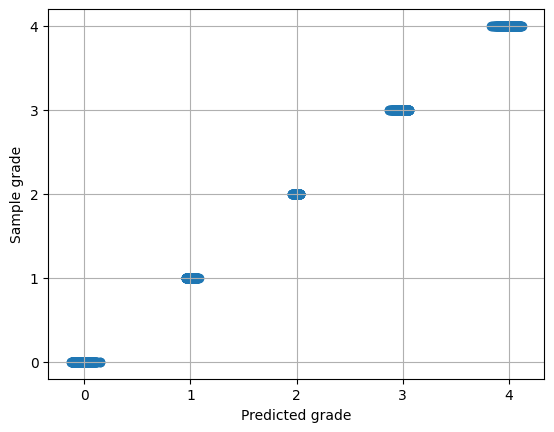

Training the model took 0 minutes, 2 seconds.


In [15]:
# OARSI grade classifier pipeline
start = time.time()
oarsi_clf = Pipeline([('classifier', LinearRegression())])

# Spectrum = feature vector -> 727 features
oarsi_clf.fit(X_train, Y_train)

# Observe the first ten model coefficients
print('First ten model coefficients: \n', oarsi_clf['classifier'].coef_[:10])

# Predict on validation data
predictions = oarsi_clf.predict(X_val)

# Mean squared error
print('\nMean squared error: {:.3f}, R2-score {:.3f}\n'.format( 
      mean_squared_error(Y_val, predictions),
      r2_score(Y_val, predictions)))

# Display grades on a scatter plot
plt.scatter(predictions, Y_val)
plt.xlabel('Predicted grade')
plt.ylabel('Sample grade')
plt.yticks(np.arange(0, 5, 1))
plt.xticks(np.arange(0, 5, 1))
plt.grid()
plt.show()

# Predict on test for later
predictions_linear = oarsi_clf.predict(X_test)
# Limit the possible range
y_min, y_max = np.min(Y_train), np.max(Y_train)
predictions_linear[predictions_linear < y_min] = y_min
predictions_linear[predictions_linear > y_max] = y_max

# Check training duration  
dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

As we can see from the mean squared error (MSE=0), R2 score (R2=1) and the scatter plot, the linear regression model yields a perfect grade for each pixel. However, the model coefficients seem very large (e.g. magnitude of 10^11). Our validation data has also a risk for overfitting, since we are including pixels from the same samples in both splits. 

Next, we will use **regularization** to limit the range of model coefficients. This means that the model is penalized for including large weights. Most commonly two types of regularization terms are used:

*   **Lasso (L1)**: sum the **absolute** values of the coefficients
*   **Ridge (L2)**: sum the **squared** values of the coefficients

The main difference is that L1 regularization tends to set some of the features to 0, whereas L2 keeps at least a small coefficient for the features. The regularization is multiplied with coefficient **alpha** to control the amount of penalty induced for the model. Note that alpha is a **hyperparameter** that should be ideally tuned using a hyperparameter search algorithm (similar to tutorial 2).

We should also **scale the features** to the **mean and standard deviation** of the training data distribution. Most machine learning models work better on scaled features.

**Least absolute shrinkage and selection operator (Lasso) regression:**

First ten model coefficients: 
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]

Mean squared error: 0.506, R2-score 0.769



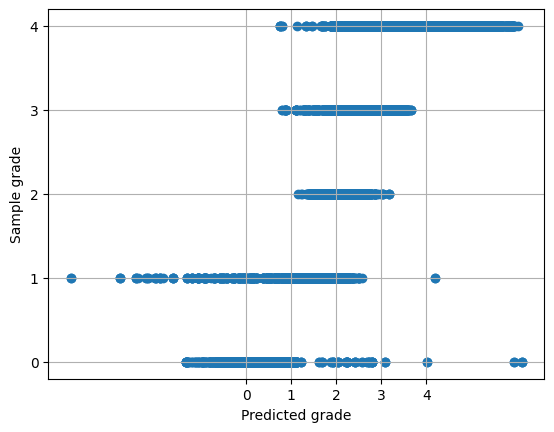

Training the model took 0 minutes, 2 seconds.


In [16]:
# Lasso regularization and feature scaling
start = time.time()
alpha = 0.1
oarsi_clf = Pipeline([('scaler', StandardScaler()),
                      ('classifier', Lasso(alpha=alpha, random_state=seed))])

# Spectrum = feature vector -> 727 features
oarsi_clf.fit(X_train, Y_train)

print('First ten model coefficients: \n', oarsi_clf['classifier'].coef_[:10])

# Predict on validation data
predictions = oarsi_clf.predict(X_val)
print('\nMean squared error: {:.3f}, R2-score {:.3f}\n'.format( 
      mean_squared_error(Y_val, predictions),
      r2_score(Y_val, predictions)))

# Show validation results on a scatter plot
plt.scatter(predictions, Y_val)
plt.xlabel('Predicted grade')
plt.ylabel('Sample grade')
plt.yticks(np.arange(0, 5, 1))
plt.xticks(np.arange(0, 5, 1))
plt.grid()
plt.show()

# Predict on test for later
oarsi_clf['scaler'].fit(X_test)  # Scale to mean and std of test set
predictions_lasso = oarsi_clf.predict(X_test)

# Check training duration  
dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

Note that all of the first ten features are set to zero. The features are now much more heavily constrained compared to the plain regression model. **Note: you can try to change the alpha value for different results (e.g. high enough alpha value returns a constant prediction).**

As you can see, many predictions are actually outside the range of grades included. A simple trick is to limit the range of predictions to the target range. Let's see the results after the transformation:

Mean squared error: 0.455, R2-score 0.792



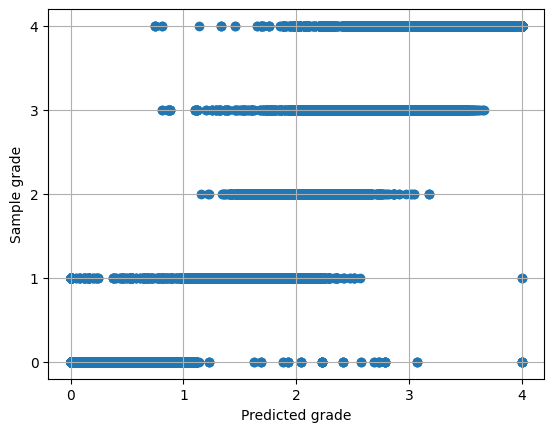

In [17]:
# Lower and upper boundaries for prediction
y_min, y_max = np.min(Y_train), np.max(Y_train)
predictions[predictions < y_min] = y_min
predictions[predictions > y_max] = y_max

print('Mean squared error: {:.3f}, R2-score {:.3f}\n'.format( 
      mean_squared_error(Y_val, predictions),
      r2_score(Y_val, predictions)))

# Show validation results on a scatter plot
plt.scatter(predictions, Y_val)
plt.xlabel('Predicted grade')
plt.ylabel('Sample grade')
plt.yticks(np.arange(0, 5, 1))
plt.xticks(np.arange(0, 5, 1))
plt.grid()

# Predict on test for later
predictions_lasso[predictions_lasso < y_min] = y_min
predictions_lasso[predictions_lasso > y_max] = y_max

plt.show()

The mean squared error has improved slightly, but we can see that the result is much worse than the perfect classification of the unregularized model.

**Ridge regression**

First ten model coefficients: 
 [-0.0028616  -0.00249863 -0.00347385 -0.00457253 -0.00454658 -0.00418035
 -0.00460637 -0.00461927 -0.00454714 -0.00472004]

Mean squared error: 1.100, R2-score 0.498



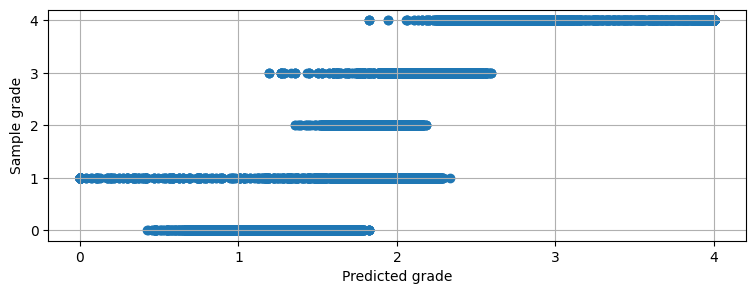

Training the model took 0 minutes, 2 seconds.


In [26]:
# Ridge regularization, scaling and range limit
start = time.time()
alpha = 1e6
oarsi_clf = Pipeline([('scaler', StandardScaler()),
                      ('classifier', Ridge(alpha=alpha, random_state=seed))])

# Spectrum = feature vector -> 727 features
oarsi_clf.fit(X_train, Y_train)

print('First ten model coefficients: \n', oarsi_clf['classifier'].coef_[:10])

# Predict on validation data
predictions = oarsi_clf.predict(X_val)
predictions[predictions < y_min] = y_min
predictions[predictions > y_max] = y_max
print('\nMean squared error: {:.3f}, R2-score {:.3f}\n'.format( 
      mean_squared_error(Y_val, predictions),
      r2_score(Y_val, predictions)))

# Show validation results on a scatter plot
plt.scatter(predictions, Y_val)
plt.xlabel('Predicted grade')
plt.ylabel('Sample grade')
plt.yticks(np.arange(0, 5, 1))
plt.xticks(np.arange(0, 5, 1))
plt.grid()
plt.show()

# Predict on test for later
oarsi_clf['scaler'].fit(X_test)  # Scale to mean and std of test set
predictions_ridge = oarsi_clf.predict(X_test)
predictions_ridge[predictions_ridge < y_min] = y_min
predictions_ridge[predictions_ridge > y_max] = y_max

# Check training duration  
dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

Due to the squared regularization term, the optimization returns larger weights for the features. However, there is still a high risk for overfitting due to the large amount of features.

# 4. Dimensionality reduction

A common method for reducing feature dimensionality is using **Principal component analysis (PCA)**. It transfers the features to another coordinate system, where highly correlated features are represented as one feature. The algorithm aims to **minimize the loss of information** due to feature reduction. The user can preselect the desired number of features, or the algorithm can select the number of features based on the **explained variance** in data.

Number of components: 
 7
Components' explained variance: 
 [0.73437367 0.10082389 0.03590716 0.03111212 0.02459318 0.01327825
 0.01057162]
First ten model coefficients: 
 [-0.00409868 -0.04683406  0.03638677 -0.00419433 -0.20420747  0.00319308
  0.23736688]

Mean squared error: 0.680, R2-score 0.689



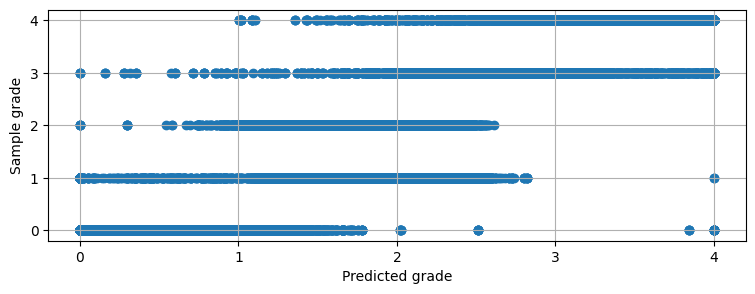

Training the model took 0 minutes, 1 seconds.


In [27]:
# PCA and Ridge regression

# Parameters
alpha = 1
components = 0.95

# Create the extended pipeline
start = time.time()
oarsi_clf = Pipeline([('scaler', StandardScaler()),
                      ('pca', PCA(n_components=components, random_state=seed)),
                      ('classifier', Ridge(alpha=alpha, random_state=seed))])

# Train the model
oarsi_clf.fit(X_train, Y_train)

# Details of the trained model
print('Number of components: \n', len(oarsi_clf['pca'].components_))
print('Components\' explained variance: \n', oarsi_clf['pca'].explained_variance_ratio_[:10])
print('First ten model coefficients: \n', oarsi_clf['classifier'].coef_[:10])

# Predict on validation data
predictions = oarsi_clf.predict(X_val)
predictions[predictions < y_min] = y_min
predictions[predictions > y_max] = y_max
print('\nMean squared error: {:.3f}, R2-score {:.3f}\n'.format( 
      mean_squared_error(Y_val, predictions),
      r2_score(Y_val, predictions)))

# Show validation results on a scatter plot
plt.scatter(predictions, Y_val)
plt.xlabel('Predicted grade')
plt.ylabel('Sample grade')
plt.yticks(np.arange(0, 5, 1))
plt.xticks(np.arange(0, 5, 1))
plt.grid()
plt.show()

# Predict on test for later
oarsi_clf['scaler'].fit(X_test)  # Scale to mean and std of test set
predictions_pca = oarsi_clf.predict(X_test)
predictions_pca[predictions_pca < y_min] = y_min
predictions_pca[predictions_pca > y_max] = y_max

# Check training duration  
dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

Note that 95% of the spectral information is conserved in just 7 (PCA components) instead of 727 features! We can also see that the model places a strong emphasis on the last five components (that account for the least information).

# 5. Polynomial features

Adding **polynomial features**, such as x^2, allows us to create new features from the polynomials of the original ones. Note that this still results in a **linear model**, the x^2 term could be just labeled as another weight in the model.

Number of features: 
 120
First ten model coefficients: 
 [ 0.00000000e+00  2.77106879e-05 -7.14187856e-05  1.89814843e-05
  3.46223219e-06 -8.99991057e-05  7.25911003e-06  5.94779395e-05
  2.11125340e-04  5.21605050e-04]

Mean squared error: 1.253, R2-score 0.428



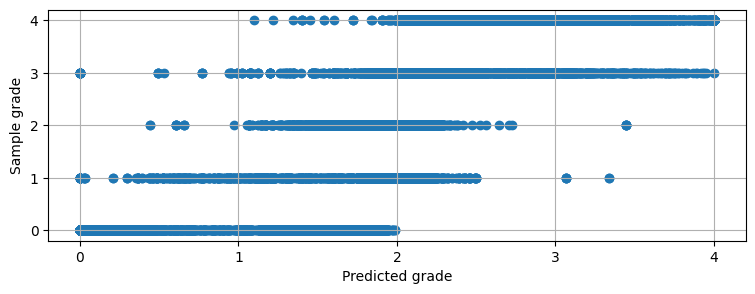

Training the model took 0 minutes, 2 seconds.


In [29]:
# Added polynomial features

# Parameters
degree = 3
components = 0.95
alpha = 1e9

# Create the extended pipeline
start = time.time()
oarsi_clf = Pipeline([('scaler', StandardScaler()),
                      ('pca', PCA(n_components=components, random_state=seed)),
                      ('polynomial', PolynomialFeatures(degree=degree)),
                      ('classifier', Ridge(alpha=alpha, random_state=seed))])

# Train the model
oarsi_clf.fit(X_train, Y_train)

# Display model details
print('Number of features: \n', len(oarsi_clf['classifier'].coef_))
print('First ten model coefficients: \n', oarsi_clf['classifier'].coef_[:10])

# Predict on validation data
predictions = oarsi_clf.predict(X_val)
predictions[predictions < y_min] = y_min
predictions[predictions > y_max] = y_max
print('\nMean squared error: {:.3f}, R2-score {:.3f}\n'.format( 
      mean_squared_error(Y_val, predictions),
      r2_score(Y_val, predictions)))

# Show validation results on a scatter plot
plt.scatter(predictions, Y_val)
plt.xlabel('Predicted grade')
plt.ylabel('Sample grade')
plt.yticks(np.arange(0, 5, 1))
plt.xticks(np.arange(0, 5, 1))
plt.grid()
plt.show()

# Predict on test for later
oarsi_clf['scaler'].fit(X_test)  # Scale to mean and std of test set
predictions_pca_poly = oarsi_clf.predict(X_test)
predictions_pca_poly[predictions_pca_poly < y_min] = y_min
predictions_pca_poly[predictions_pca_poly > y_max] = y_max

# Check training duration  
dur = time.time() - start
print(f'Training the model took {dur // 60:.0f} minutes, {dur % 60:.0f} seconds.')

# 5. Evaluation of results

Now that we have fine-tuned the regression model, we can analyze the performance on the test set. We will also include **Spearman rho** to the list of metrics.

All of the steps can be compiled in a simple function:

In [30]:
def show_results(y, X, name='Experiment'):
    # MSE, R2
    print(f'\n____________\n{name}:')
    print('\nMean squared error: {:.3f}, R2-score {:.3f}\n'.format( 
        mean_squared_error(y, X),
        r2_score(y, X)))

    # Spearman correlation
    spearman = spearmanr(y, X)
    print(f'Spearman rho: {spearman[0]:.3f}, p-value {spearman[1]:.4f}')
    # Scatter plot
    plt.scatter(X, y)
    plt.xlabel('Predicted grade')
    plt.ylabel('Sample grade')
    plt.yticks(np.arange(0, 5, 1))
    plt.xticks(np.arange(0, 5, 1))
    plt.grid()
    plt.show()

Now we can call it on all the previous experiments:


____________
Linear regression (no regularization):

Mean squared error: 10.825, R2-score -4.121

Spearman rho: -0.821, p-value 0.0000


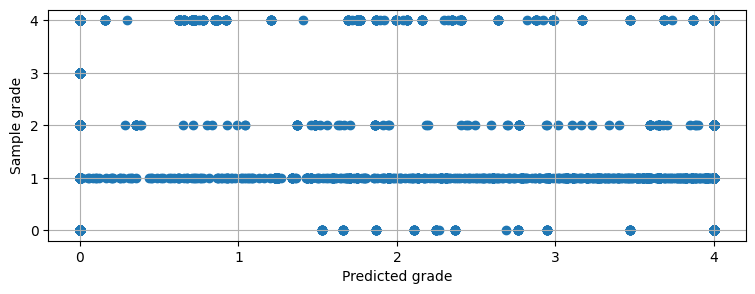


____________
Lasso regression:

Mean squared error: 5.556, R2-score -1.628

Spearman rho: -0.790, p-value 0.0000


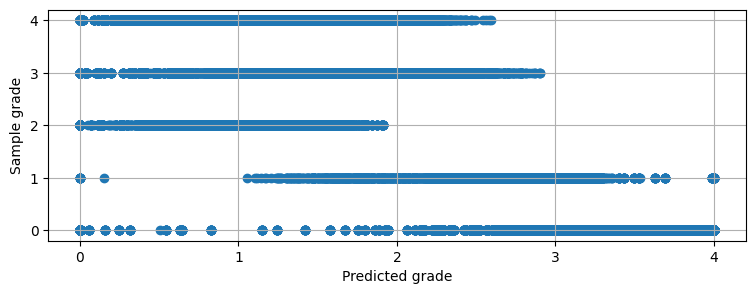


____________
Ridge regression:

Mean squared error: 3.008, R2-score -0.423

Spearman rho: -0.674, p-value 0.0000


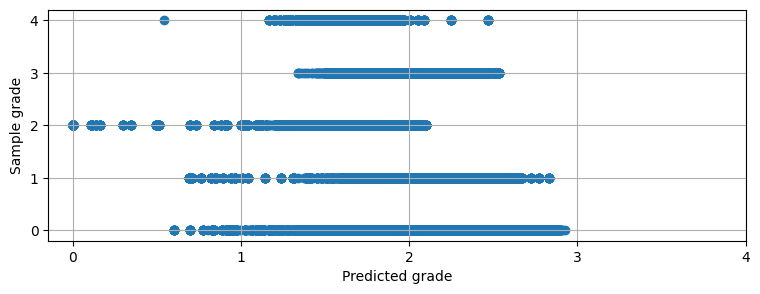


____________
PCA:

Mean squared error: 2.950, R2-score -0.395

Spearman rho: -0.404, p-value 0.0000


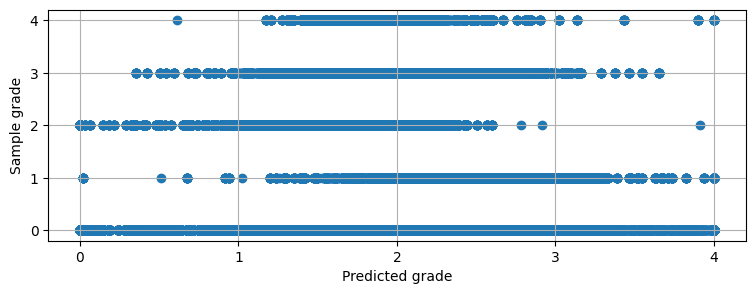


____________
PCA and polynomial features:

Mean squared error: 2.643, R2-score -0.251

Spearman rho: -0.377, p-value 0.0000


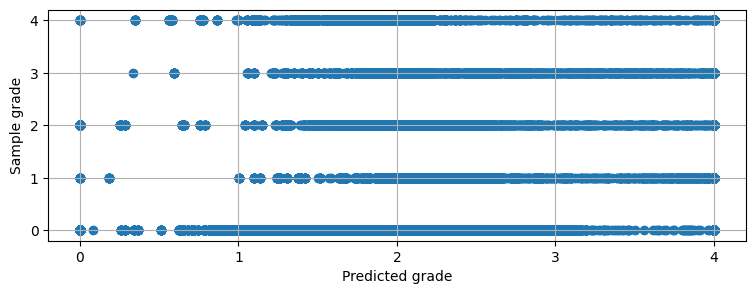

In [31]:
# Linear regression
show_results(Y_test, predictions_linear, 
             name='Linear regression (no regularization)')

# Lasso regression
show_results(Y_test, predictions_lasso, 
             name='Lasso regression')

# Ridge
show_results(Y_test, predictions_ridge, 
             name='Ridge regression')

# PCA
show_results(Y_test, predictions_pca, 
             name='PCA')

# PCA and polynomial features
show_results(Y_test, predictions_pca_poly, 
             name='PCA and polynomial features')

Unfortunately, the machine learning models did not generalize to the new dataset, and the predictions are too noisy to be useful. **What could be the possible reasons?**

# 6. Unsupervised learning: Tissue type classification

Let's see if we could utilize unsupervised methods for the spectroscopy dataset. This time, we also aim for a more simple target: to label different constituents of the imaged tissue sample, based on the spectral data.

The Raman maps include an area of bone-cartilage-interface. There are three main components that can be detected: **bone, calcified cartilage, and articular cartilage**. However, the bone and calcified cartilage have very similar properties, since they both are mineralized tissues.

To label the tissues with unsupervised learning, we can use clustering methods (such as K-means, fuzzy c-means, or hierarchical clustering)

Here we run the K-means clustering for the full spectra on each sample. It would also be possible to select a **spectral region** for the clustering (such as an interesting peak)

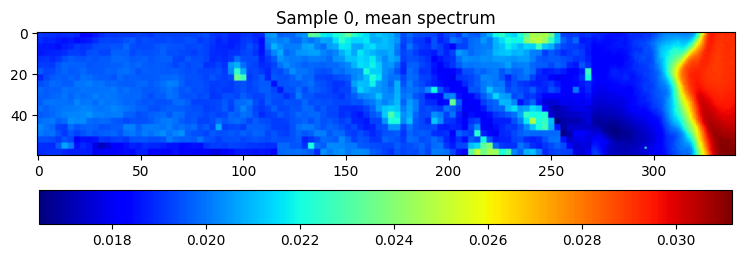

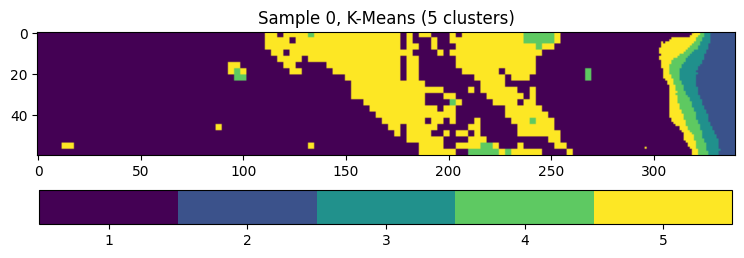

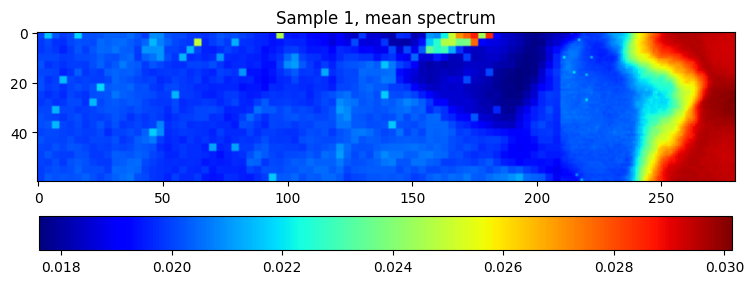

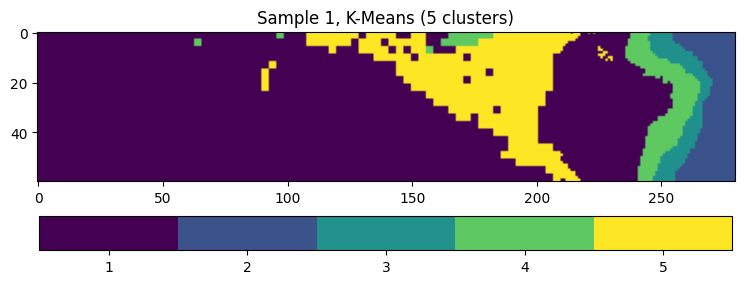

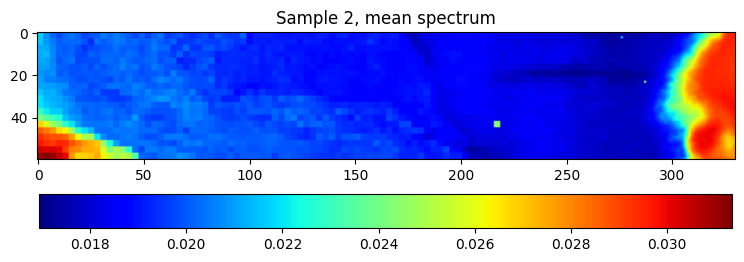

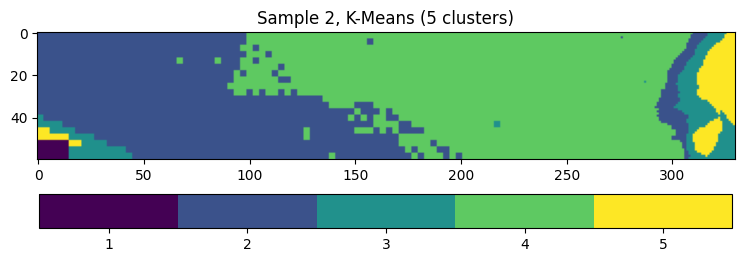

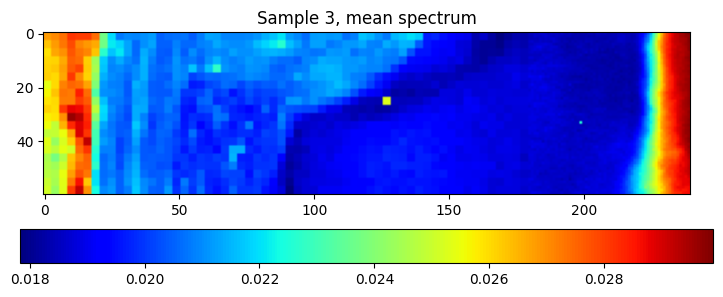

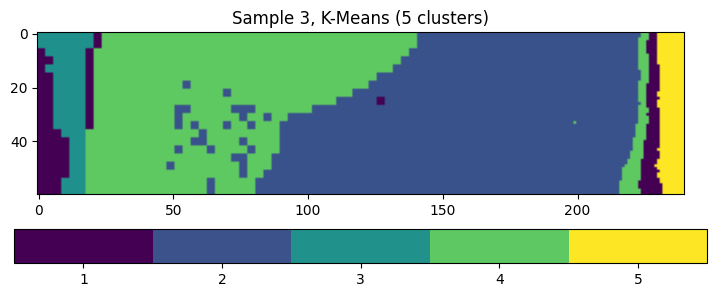

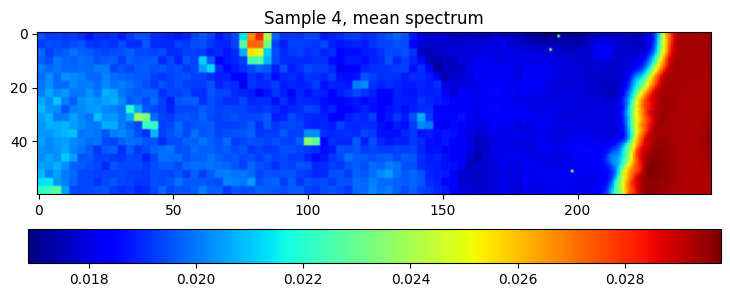

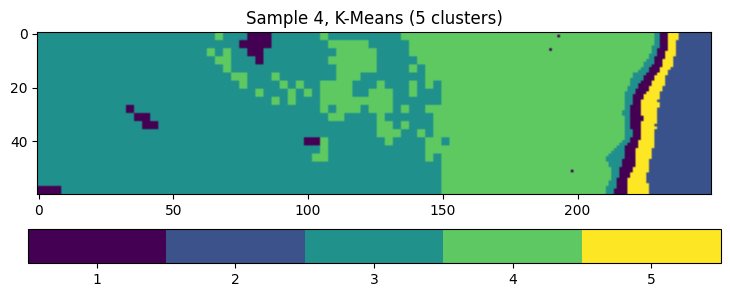

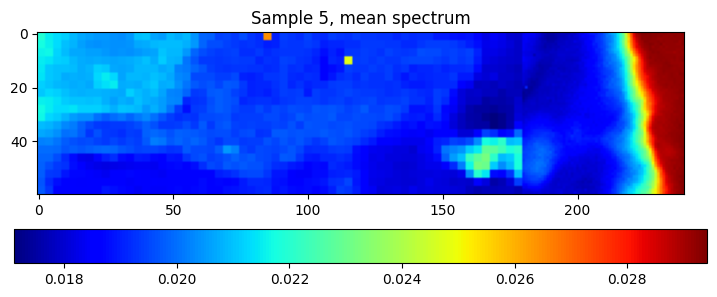

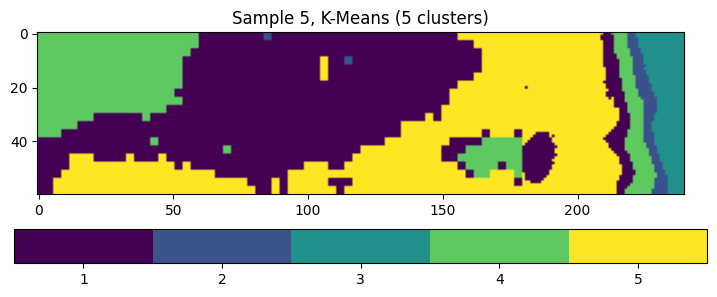

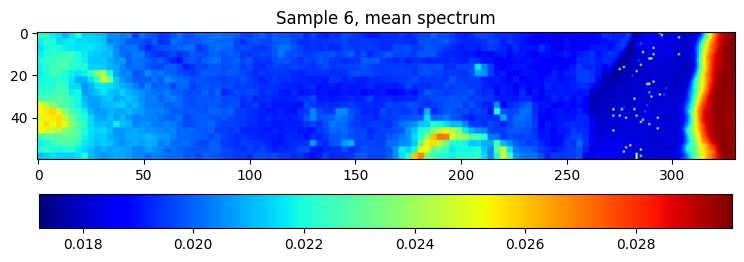

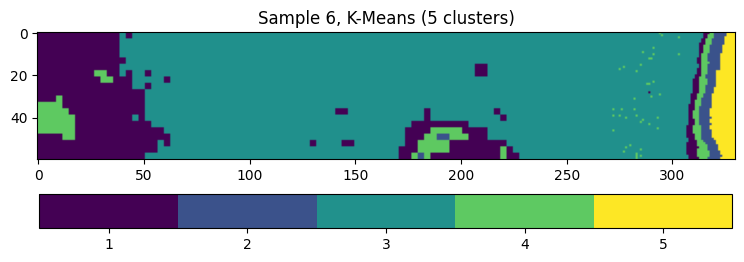

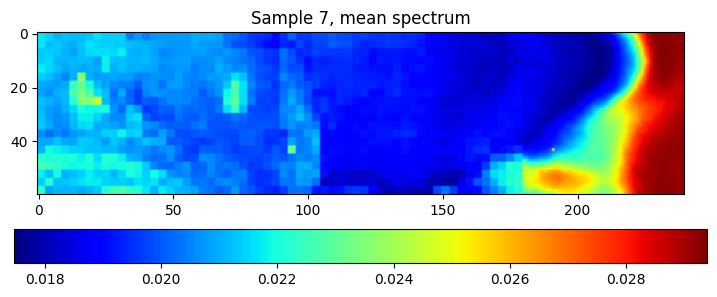

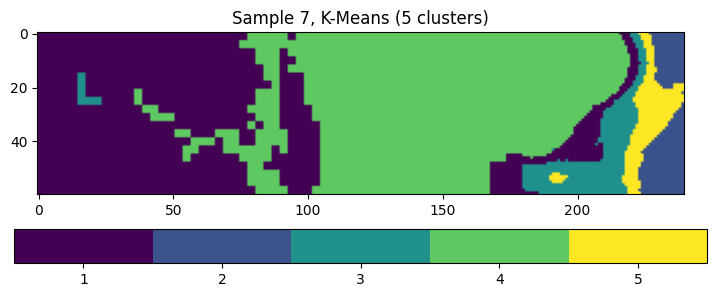

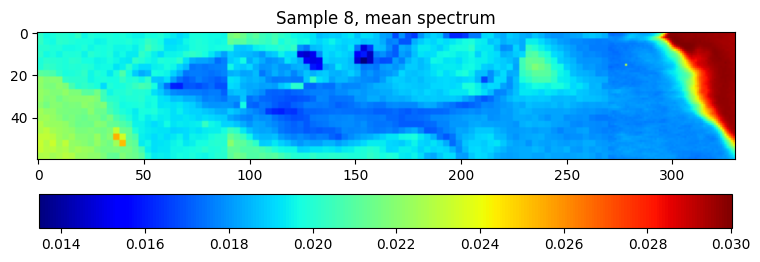

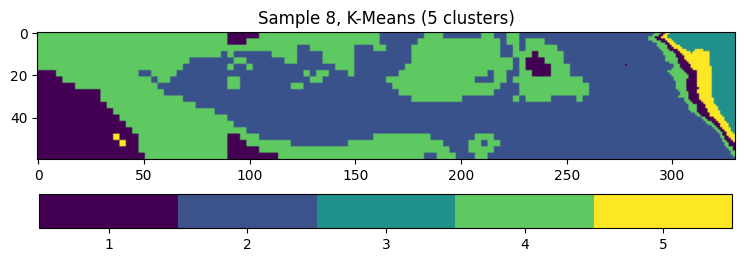

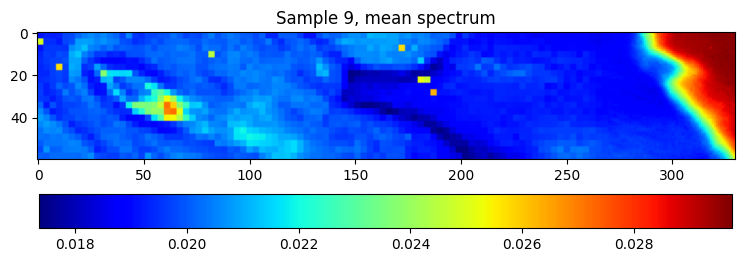

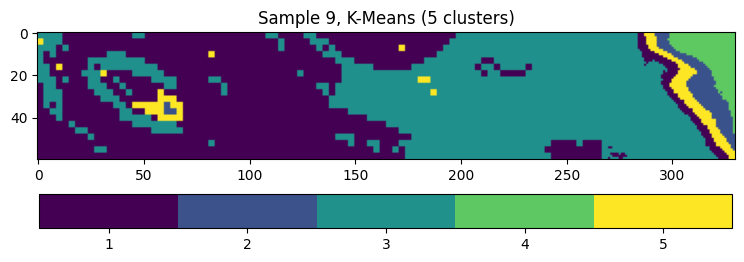

In [40]:
# KMeans
clusters = 5
kmeans = KMeans(n_clusters=clusters, random_state=seed)

for sample_id in range(len(data)):
    # Move wavenumber dimension as last
    sample = np.transpose(data[sample_id], (1, 2, 0))
    dim = sample.shape

    # Calculate K-means clustering and predict on the image
    sample_clustered = kmeans.fit_predict(sample.reshape(dim[0] * dim[1], -1))

    # Return original shape
    sample_clustered = sample_clustered.reshape(dim[0], dim[1])

    # Show results
    # Mean spectrum
    plt.imshow(np.mean(data[sample_id], axis=0), cmap='jet')
    plt.title(f'Sample {sample_id}, mean spectrum')
    plt.colorbar(orientation='horizontal')
    plt.show()

    # Clustering
    cmap = plt.cm.tab10
    plt.imshow(sample_clustered, 
               # Get less bins for the default colormap
               cmap=plt.get_cmap('viridis', clusters) # plt.cm.get_cmap('viridis', clusters)
               )
    plt.title(f'Sample {sample_id}, K-Means ({clusters} clusters)')
    cbar = plt.colorbar(orientation='horizontal', values=range(clusters))
    # Show only tick marks on middle of class
    cbar.set_ticks(range(clusters))
    # Label to start from 1
    cbar.set_ticklabels(range(1, clusters+1))
    plt.show()

We can also divide the samples into clusters using Principal component analysis (PCA). Similar to the dimensionality reduction, we can divide the spectral data into less components (minimizing information loss) that could represent some of the tissues in the sample. Nice benefit of using PCA is that, **besides its distribution, we can also visualize a spectrum of the principal component**.

Explained variance: PC1 (92.1%), PC2 (3.0%), PC3 (1.9%)


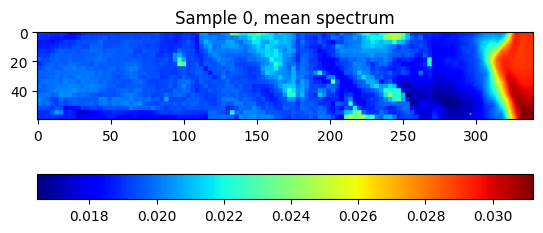

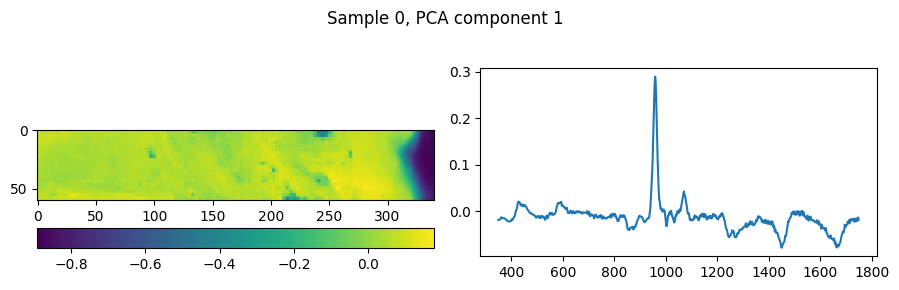

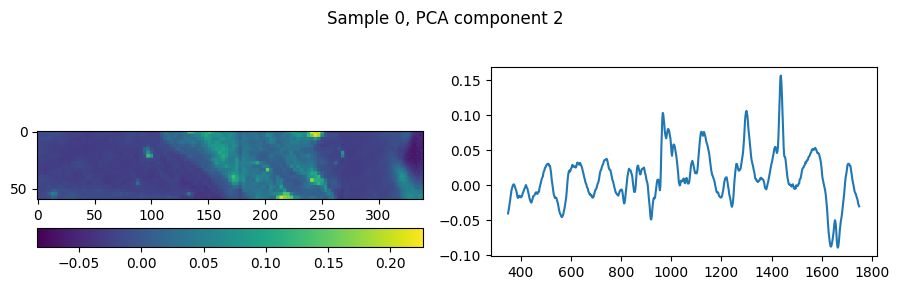

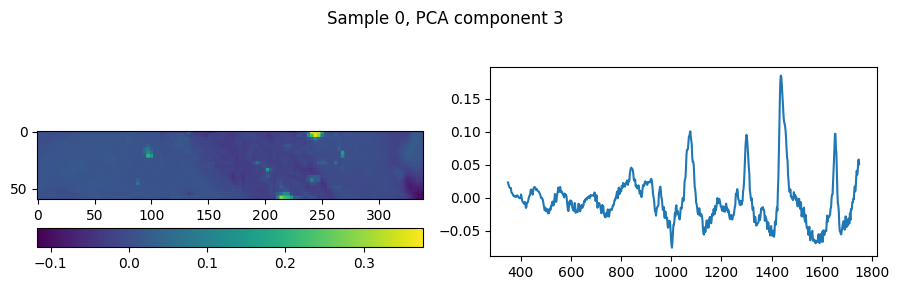

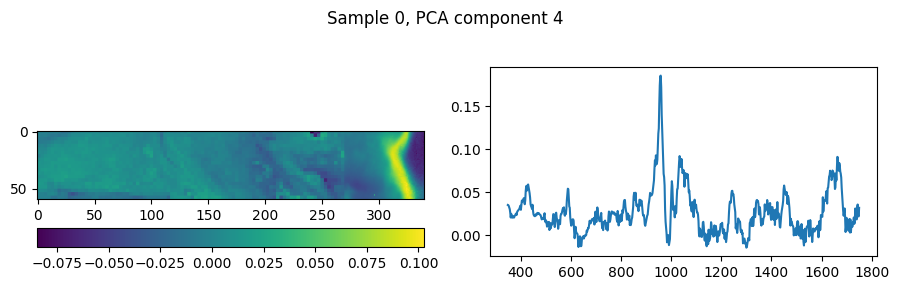

Explained variance: PC1 (95.2%), PC2 (1.8%), PC3 (1.2%)


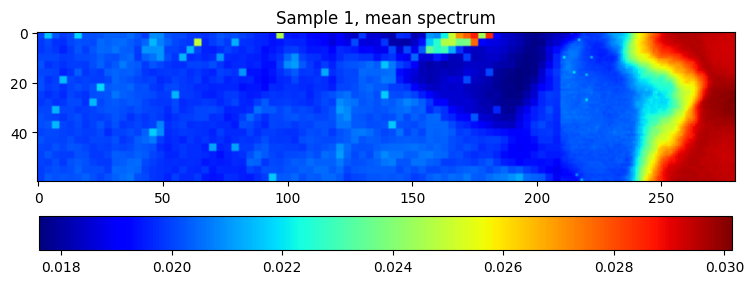

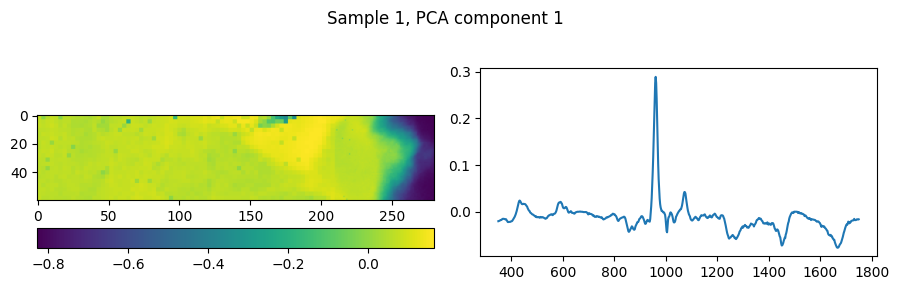

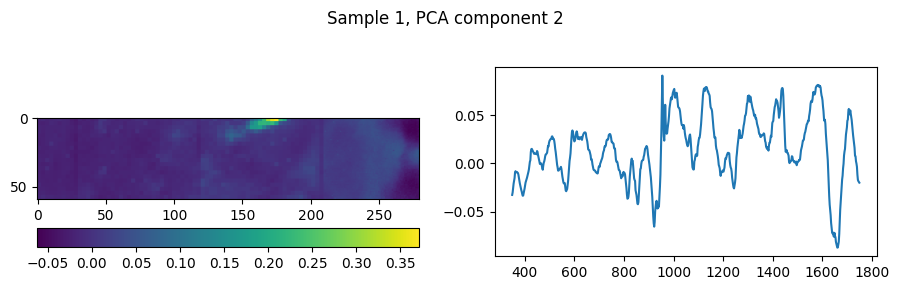

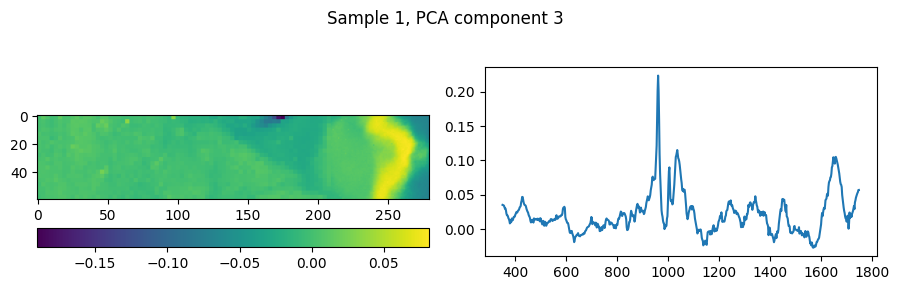

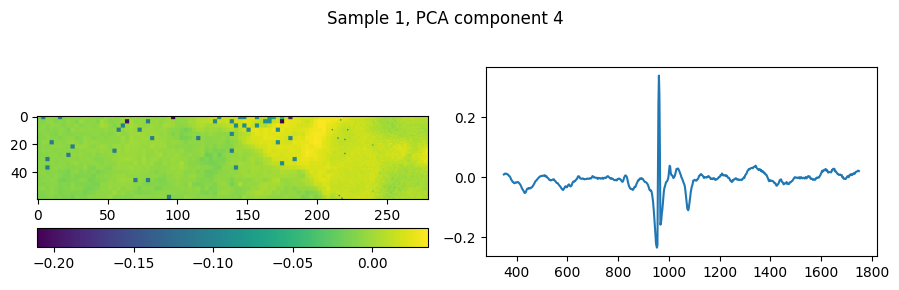

Explained variance: PC1 (93.4%), PC2 (2.4%), PC3 (1.7%)


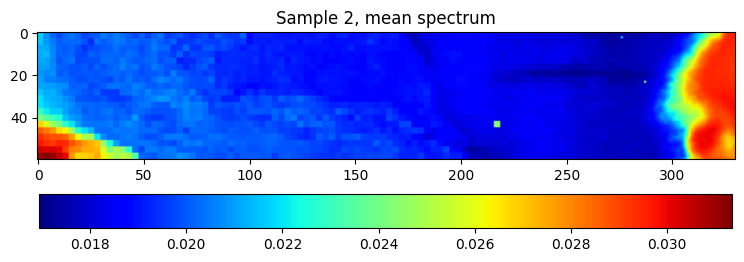

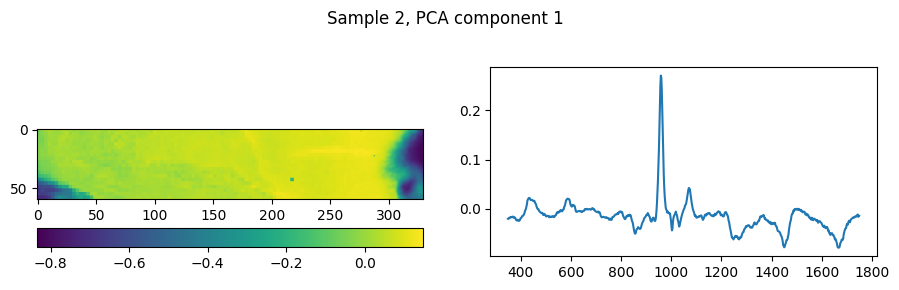

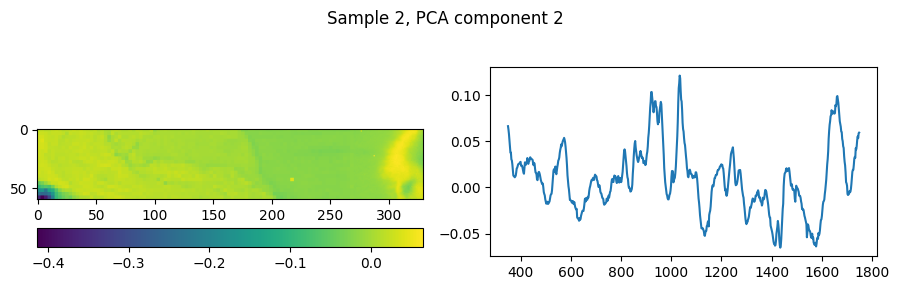

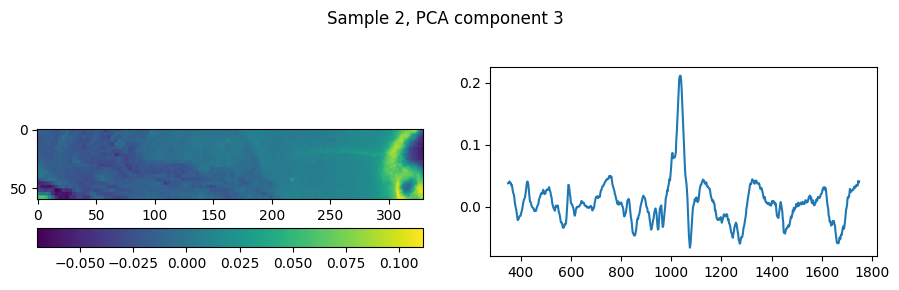

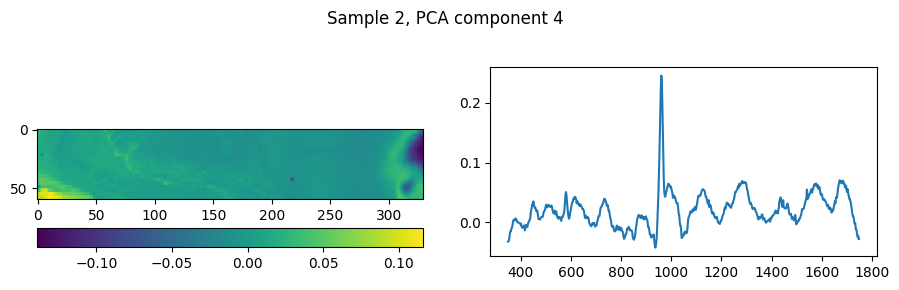

Explained variance: PC1 (90.0%), PC2 (6.2%), PC3 (1.4%)


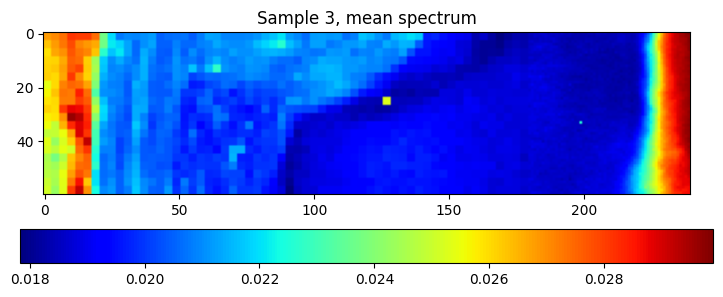

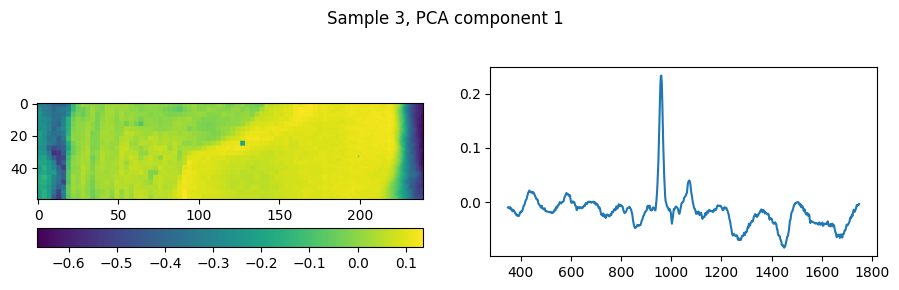

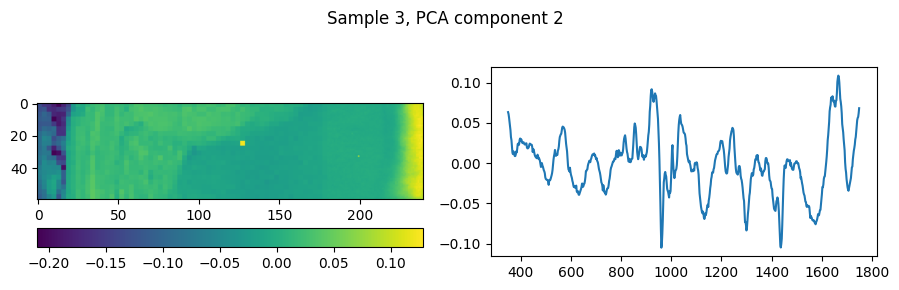

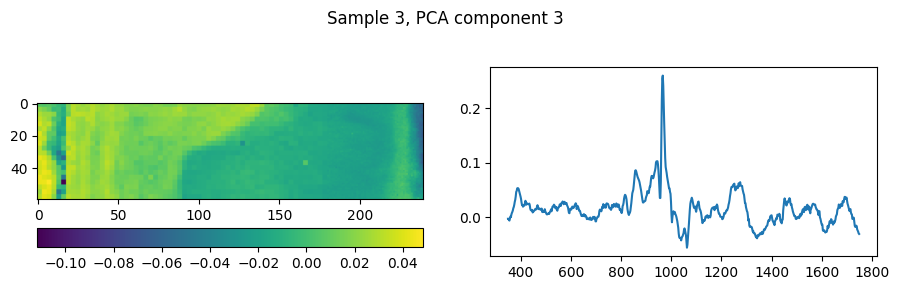

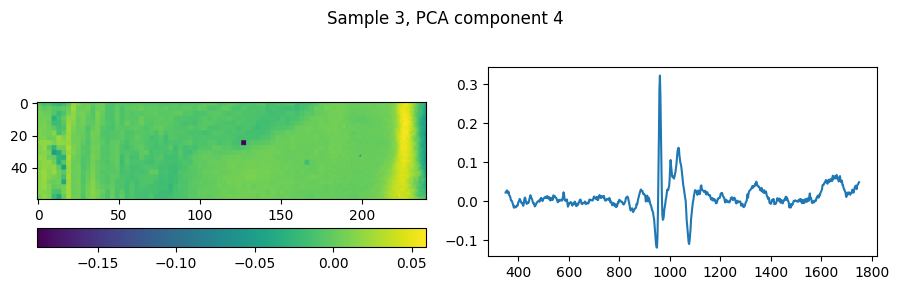

Explained variance: PC1 (97.2%), PC2 (1.0%), PC3 (0.7%)


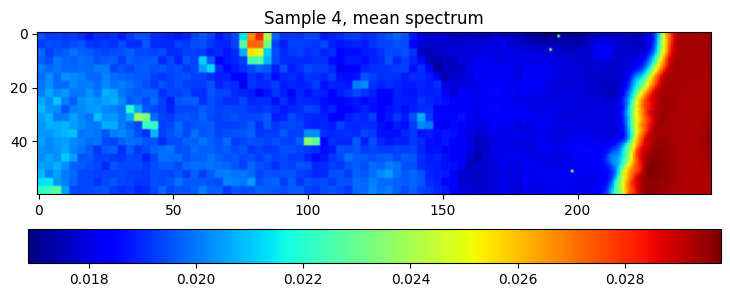

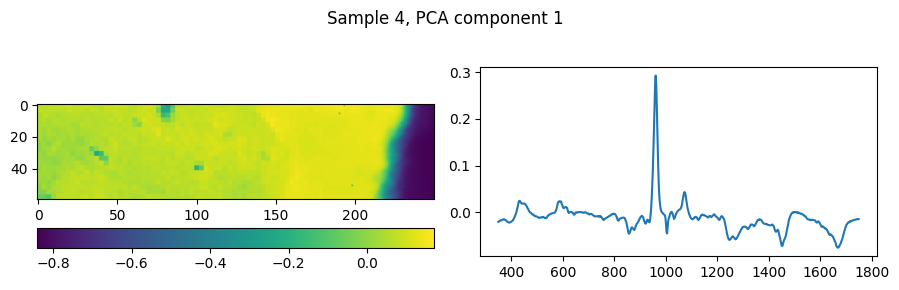

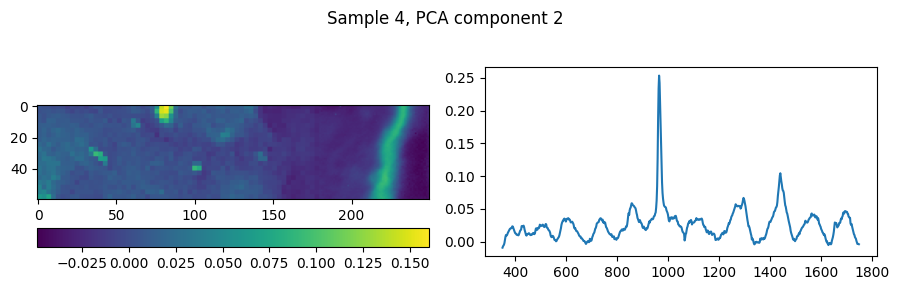

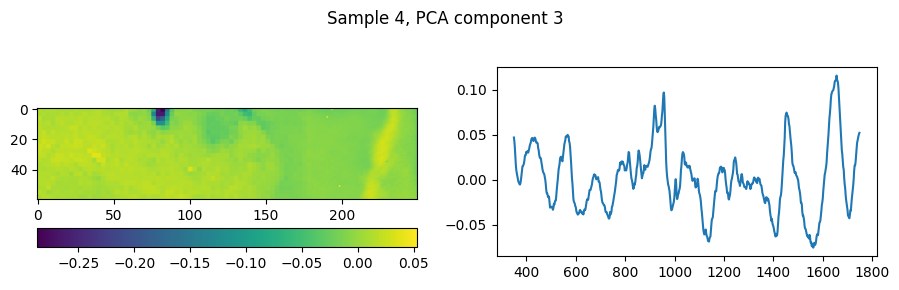

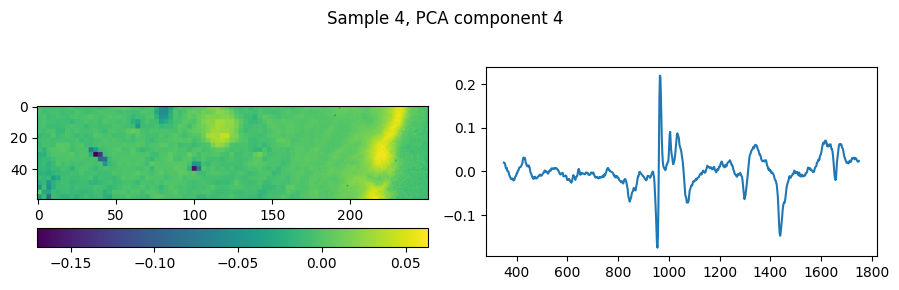

Explained variance: PC1 (96.3%), PC2 (1.5%), PC3 (1.0%)


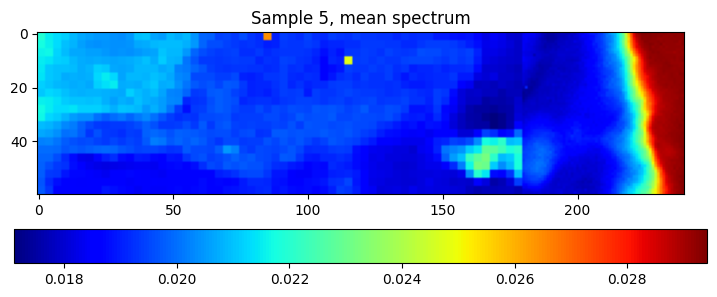

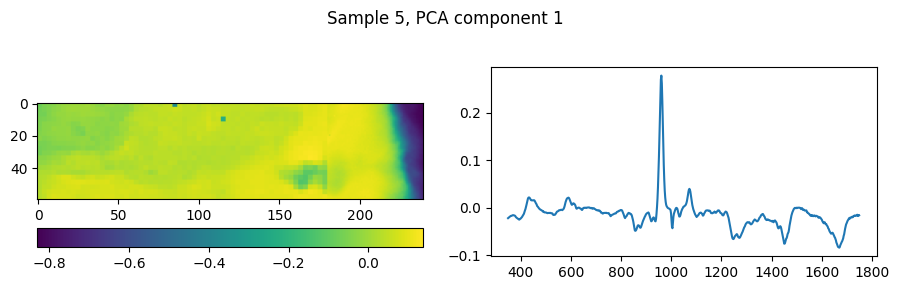

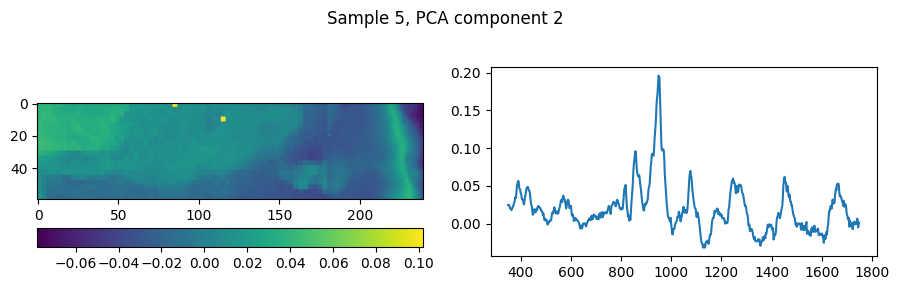

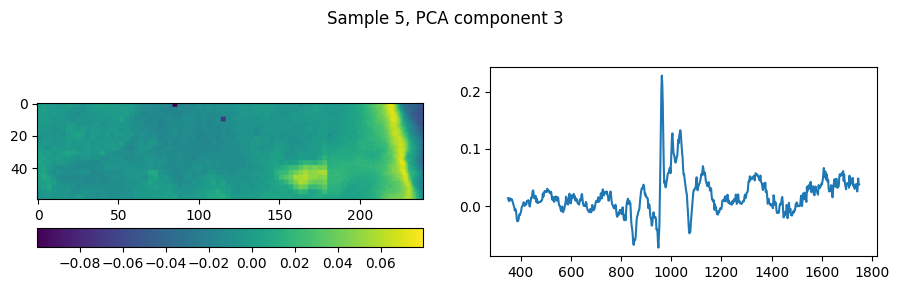

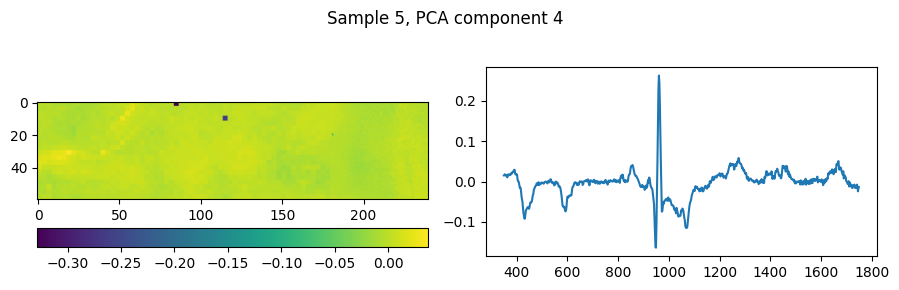

Explained variance: PC1 (92.5%), PC2 (3.0%), PC3 (1.3%)


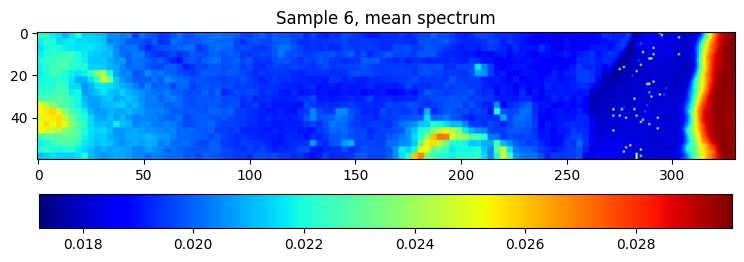

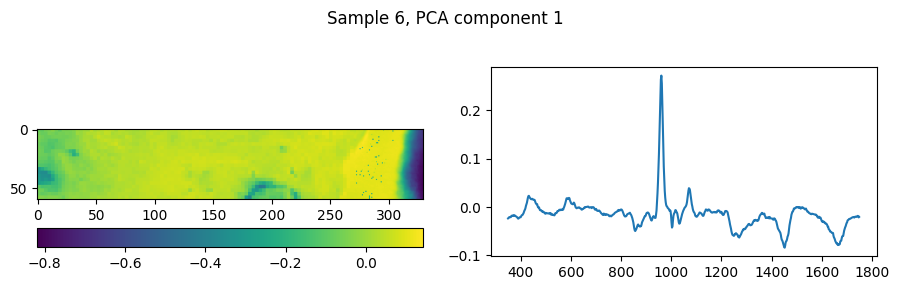

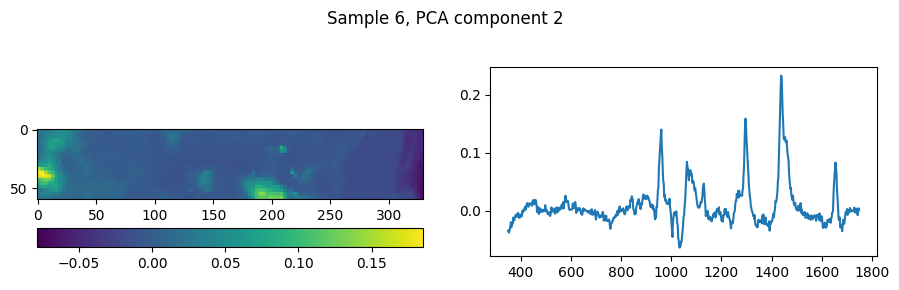

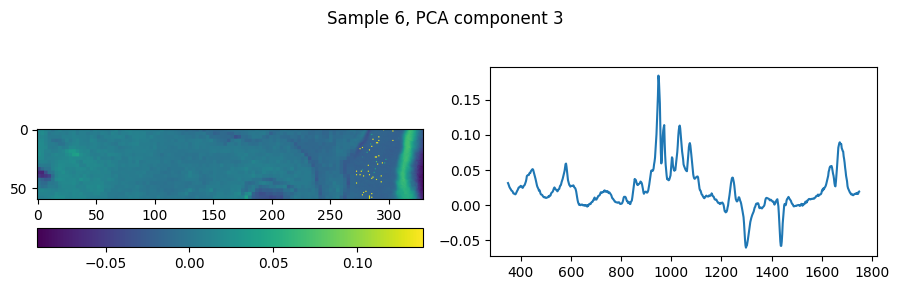

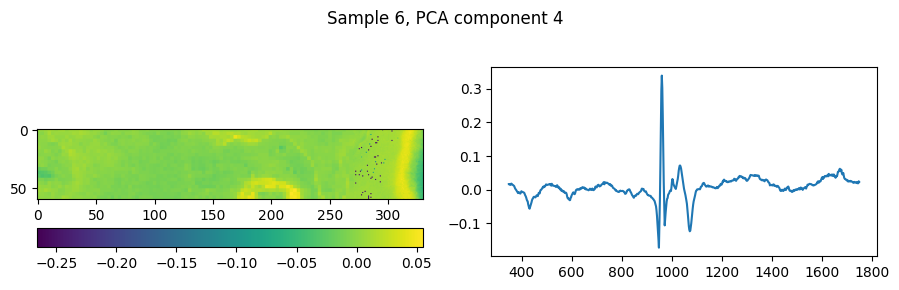

Explained variance: PC1 (95.8%), PC2 (2.1%), PC3 (0.9%)


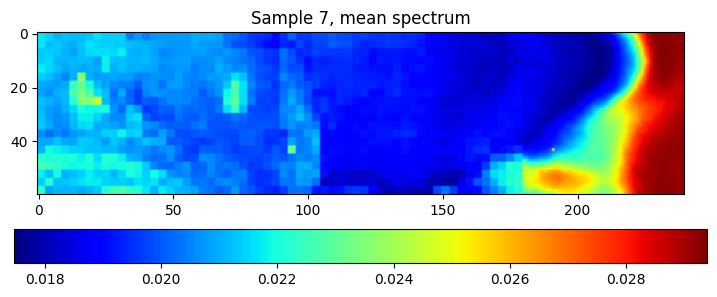

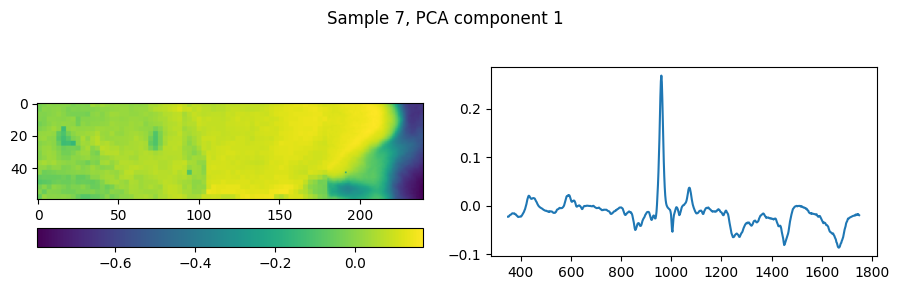

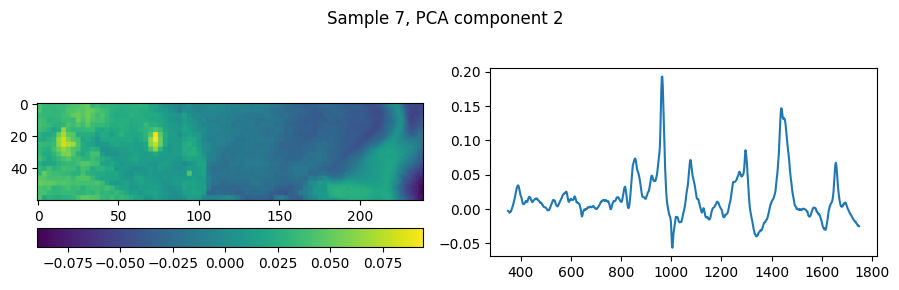

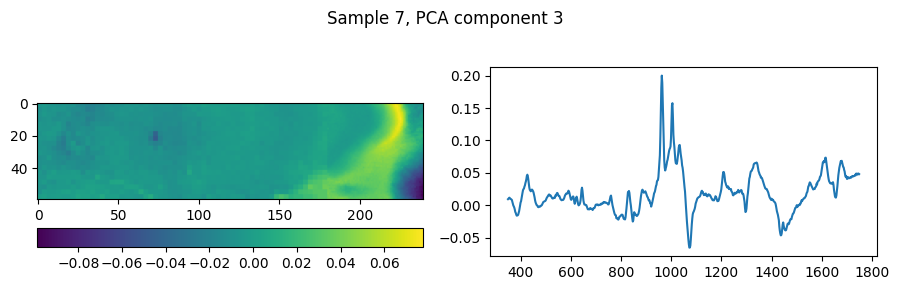

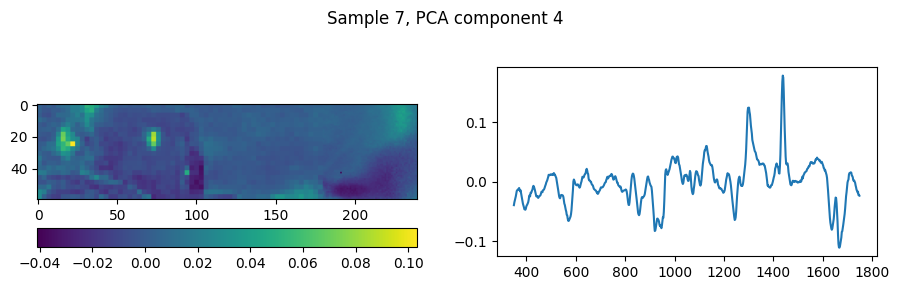

Explained variance: PC1 (95.2%), PC2 (2.5%), PC3 (0.8%)


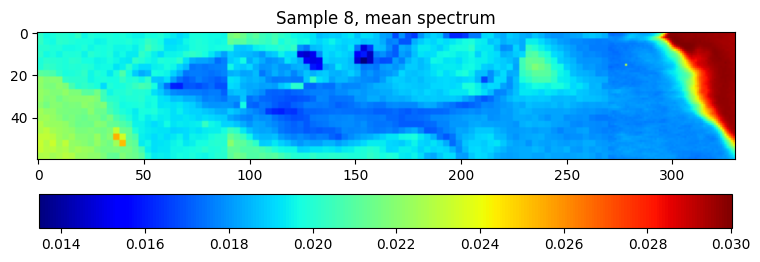

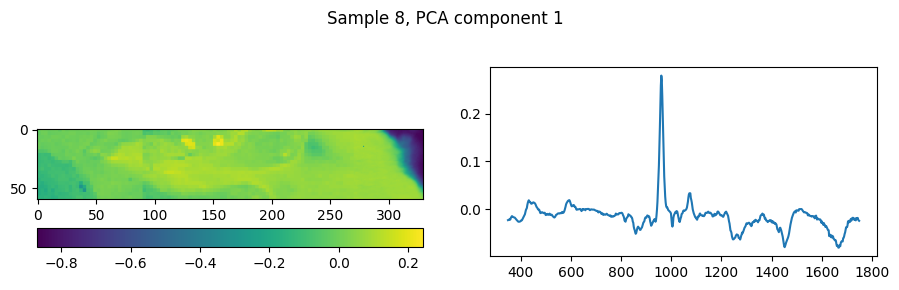

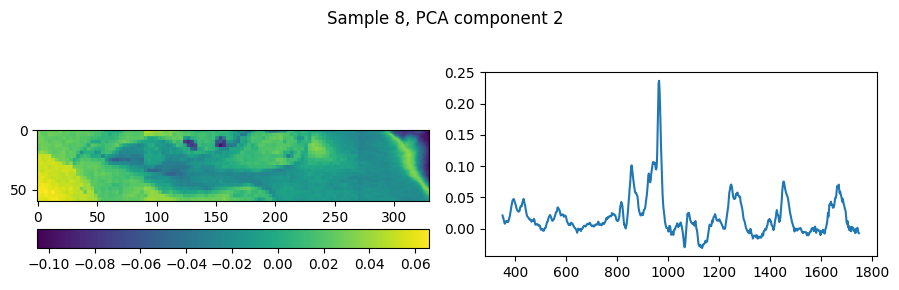

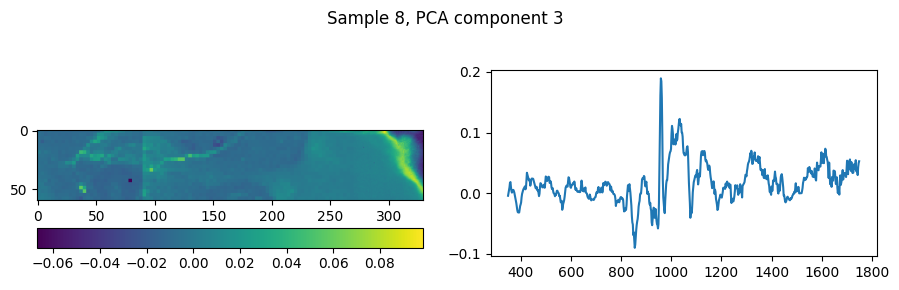

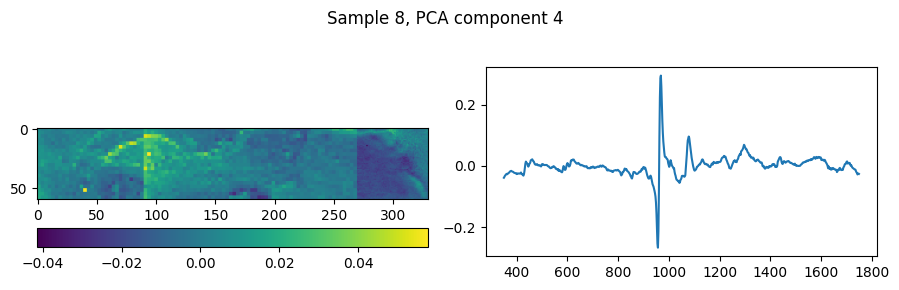

Explained variance: PC1 (93.4%), PC2 (1.7%), PC3 (1.5%)


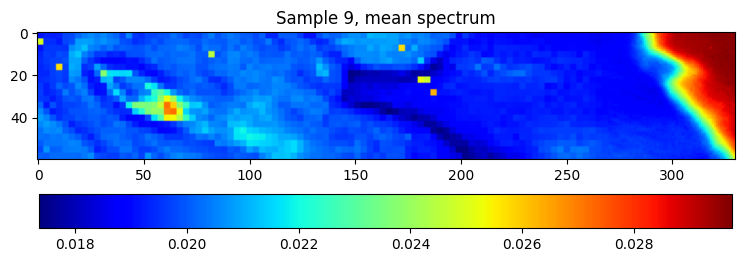

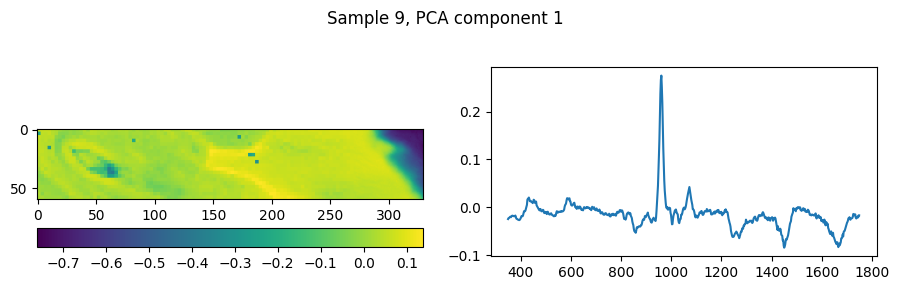

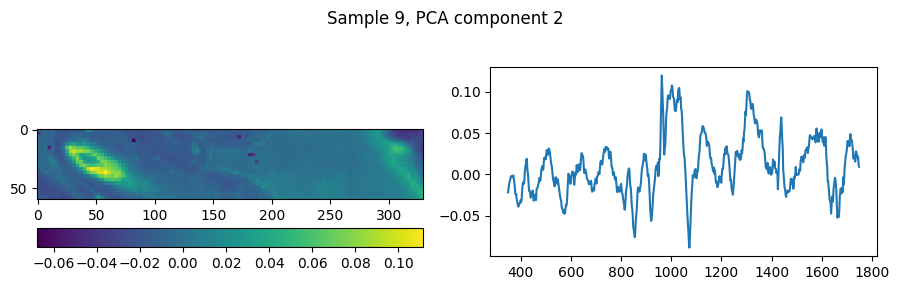

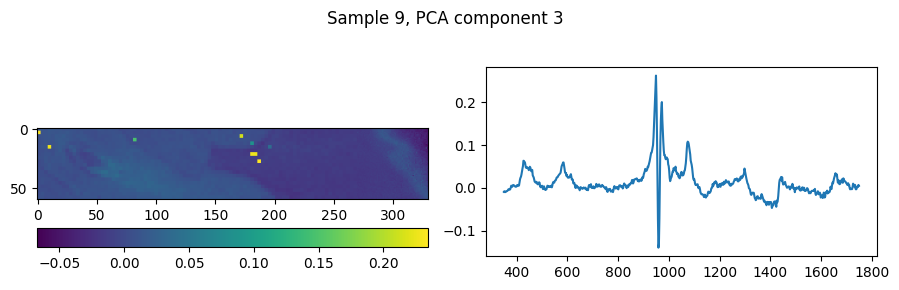

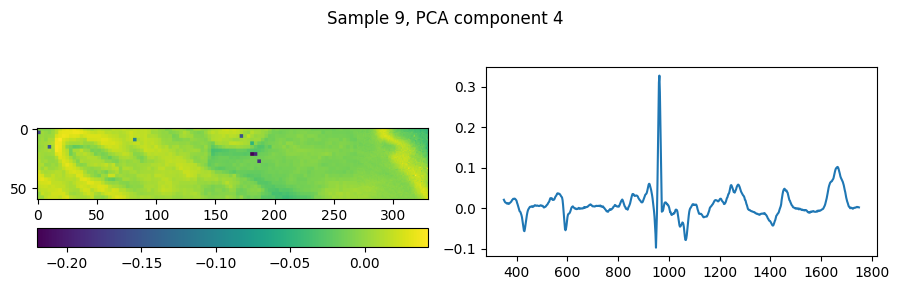

In [24]:
# PCA
components = 4
pca = PCA(n_components=components)

for sample_id in range(len(data)):
    # Move wavenumber dimension as last
    sample = np.transpose(data[sample_id], (1, 2, 0))
    dim = sample.shape

    # Calculate PCA and predict on the image
    sample_clustered = pca.fit_transform(sample.reshape(dim[0] * dim[1], -1))
    print('Explained variance: PC1 ({:.1f}%), PC2 ({:.1f}%), PC3 ({:.1f}%)'.format(
        pca.explained_variance_ratio_[0] * 100, 
        pca.explained_variance_ratio_[1] * 100,
        pca.explained_variance_ratio_[2] * 100,))

    # Return original shape
    sample_clustered = sample_clustered.reshape(dim[0], dim[1], -1)

    # Show results
    # Mean spectrum
    plt.imshow(np.mean(data[sample_id], axis=0), cmap='jet')
    plt.title(f'Sample {sample_id}, mean spectrum')
    plt.colorbar(orientation='horizontal')
    plt.show()

    # Clustering
    for c in range(components):
        # Show the distribution of the principal component
        plt.rcParams["figure.figsize"] = (9,3)
        plt.subplot(121)
        plt.imshow(sample_clustered[:, :, c])
        plt.suptitle(f'Sample {sample_id}, PCA component {c+1}')
        plt.colorbar(orientation='horizontal')

        # Show spectrum for the principal component
        plt.subplot(122)
        plt.plot(wavenumber[sample_id], pca.components_[c])
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

Each principal component has a corresponding "spectrum", containing most of the information of the Raman spectra of the sample. The **explained variance** is an estimate of the percentage of information included.

The PCA analysis seems to separate at least the cartilage and mineral components from the tissues. Interestingly, an **osteocyte** (bone cell) is highlighted in sample 9, in one of the components. The spectral information in the PCA component could even relate to the cell constituents, such as DNA, proteins or lipids.

**Independent component analysis (ICA)** tries to maximize independence of the selected components, instead of maximizing explained variance.

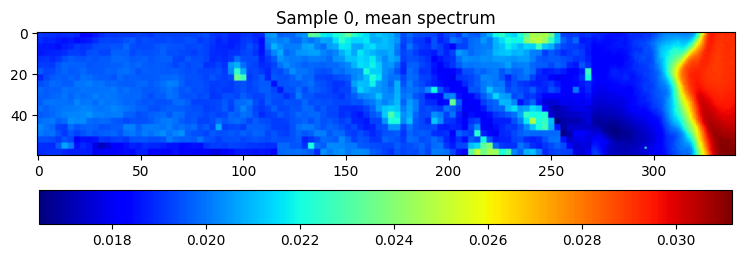

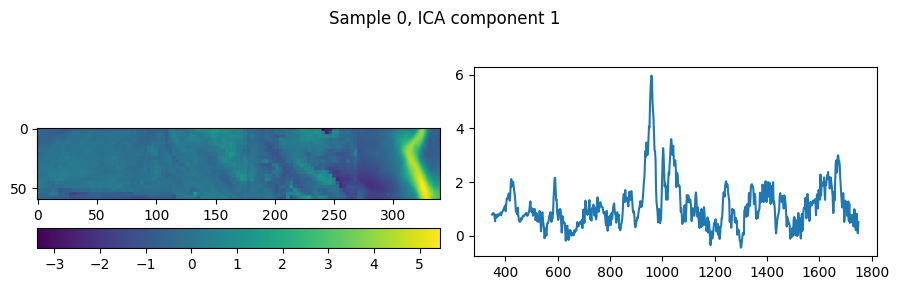

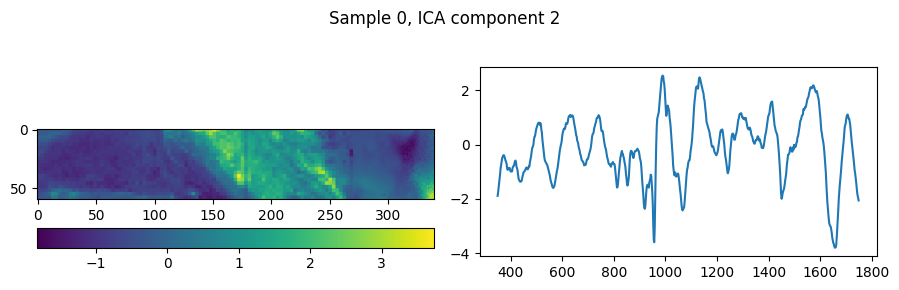

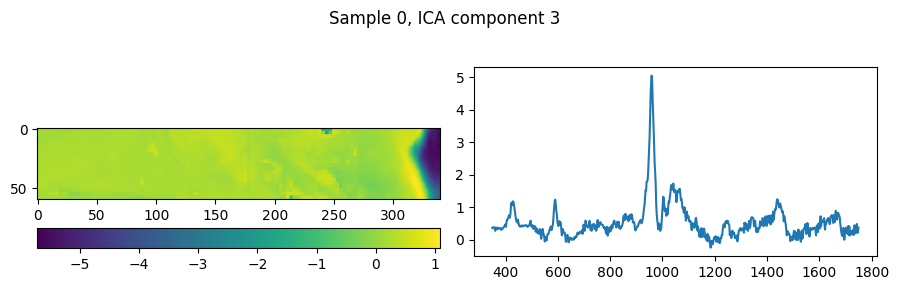

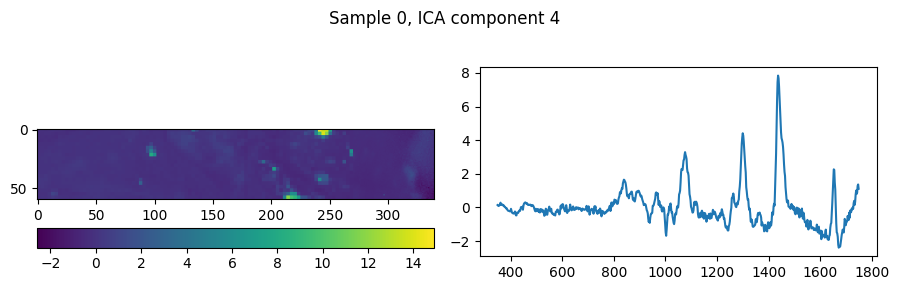

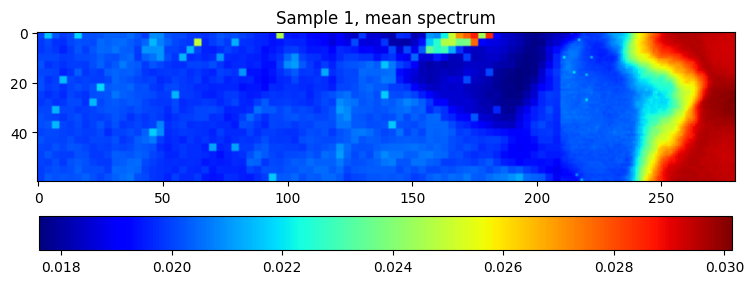

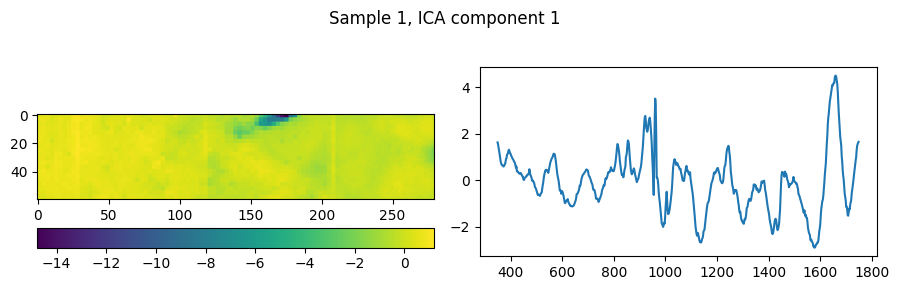

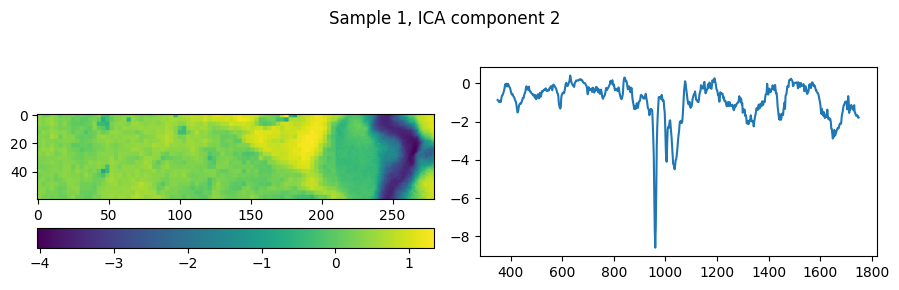

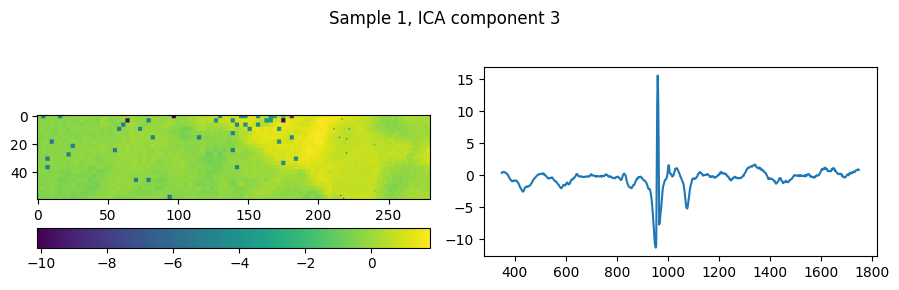

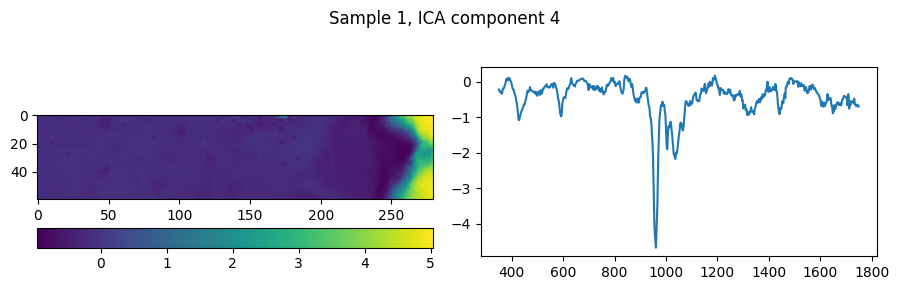

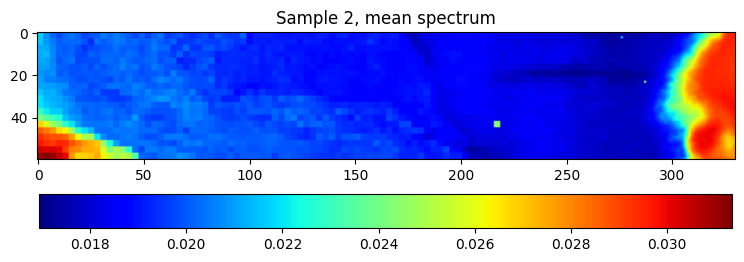

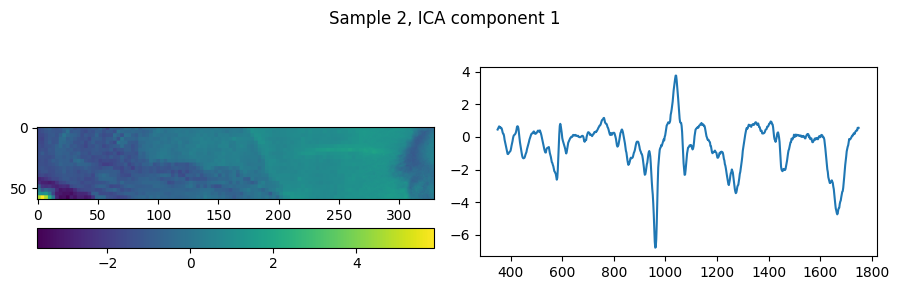

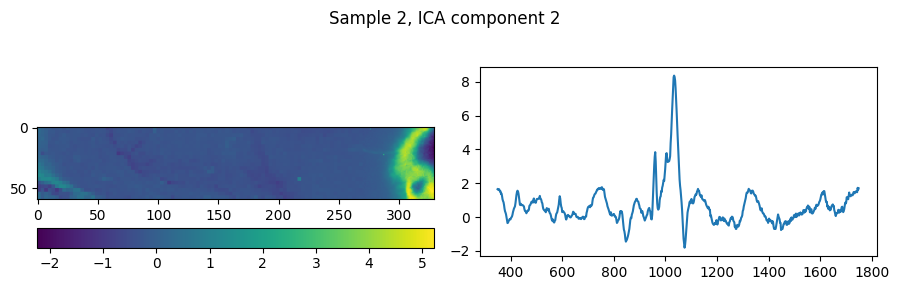

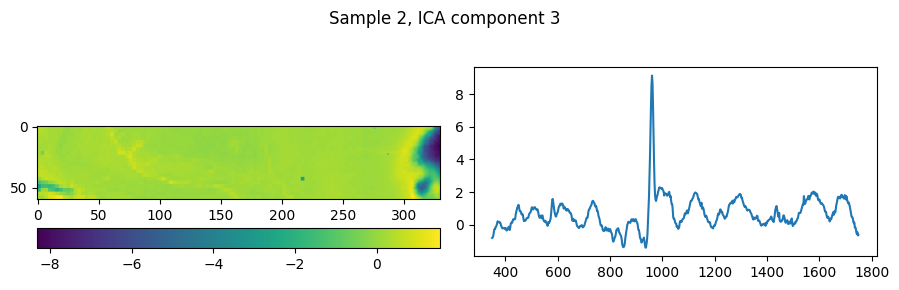

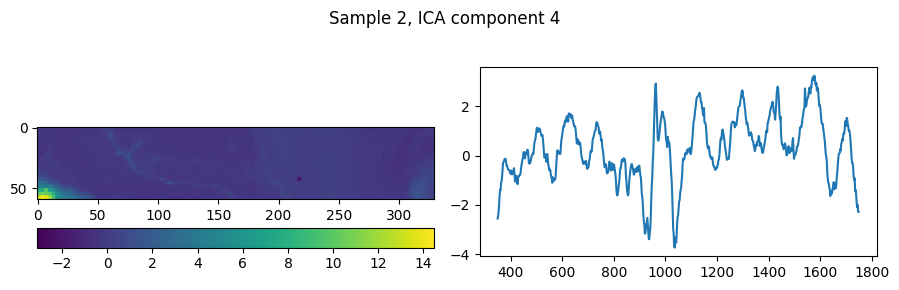

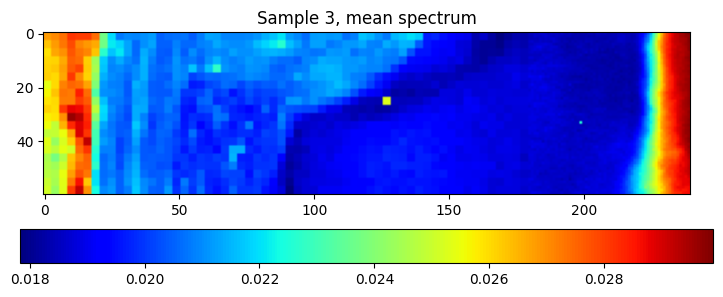

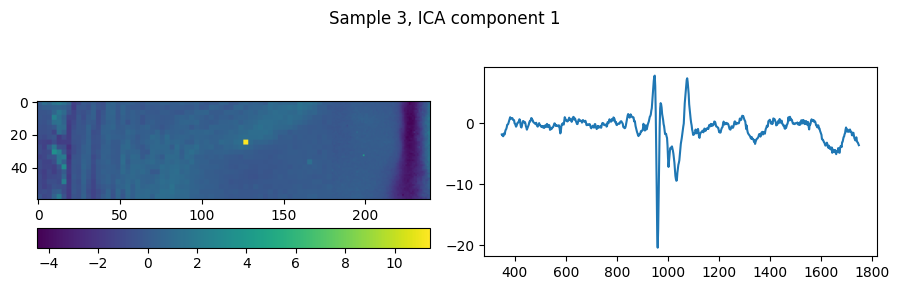

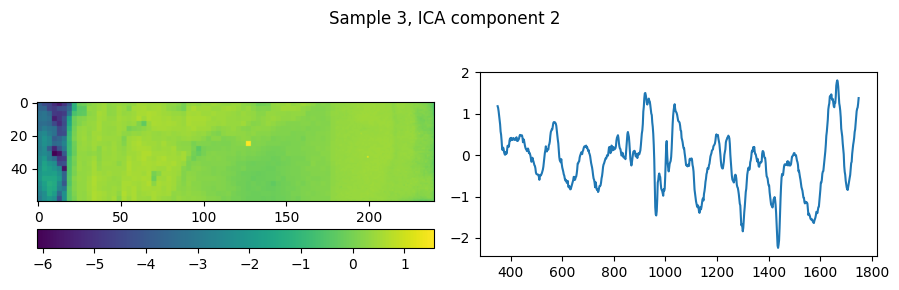

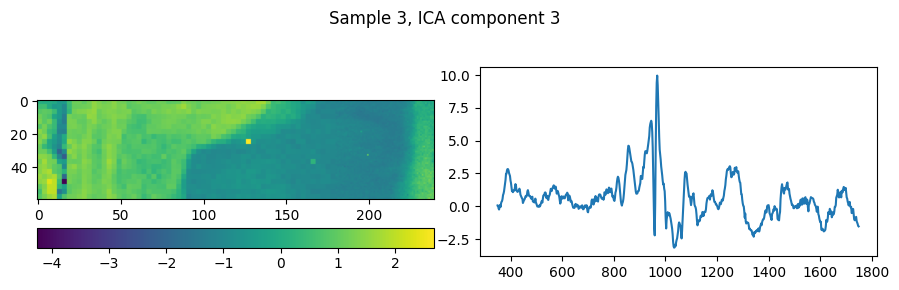

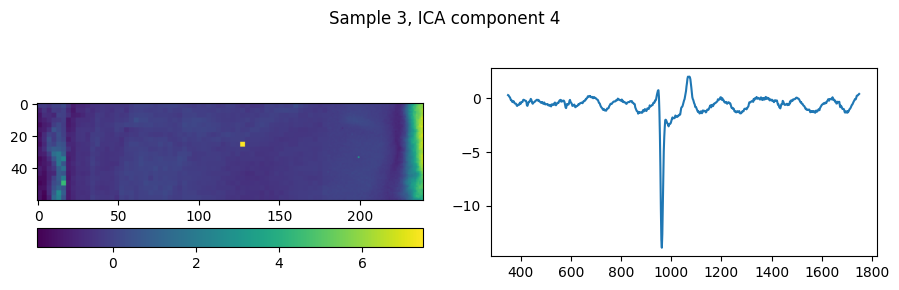

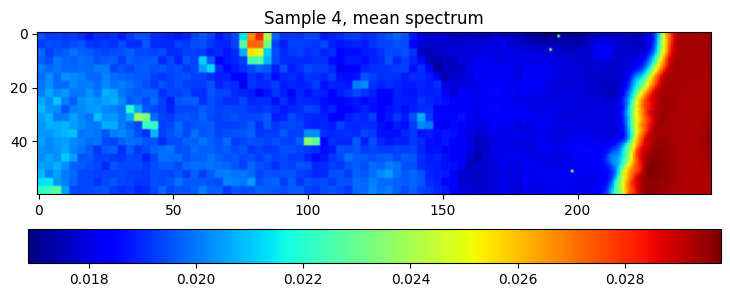

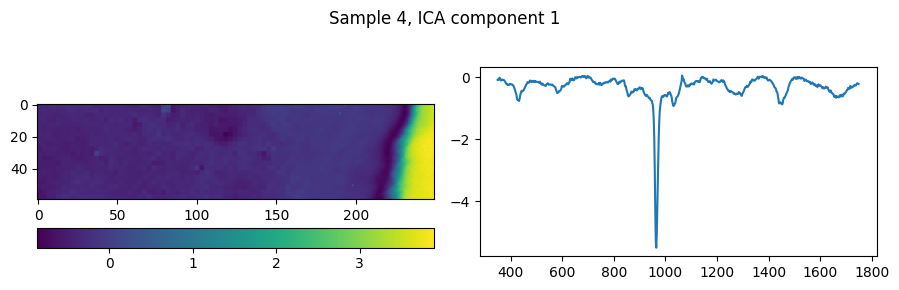

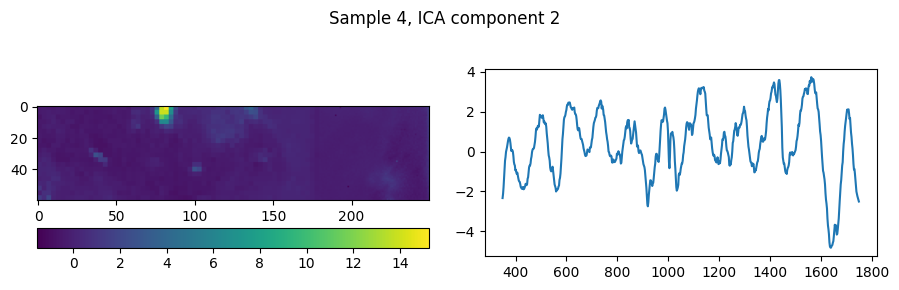

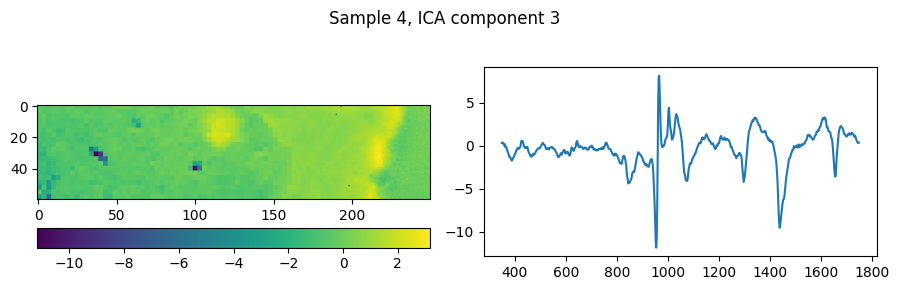

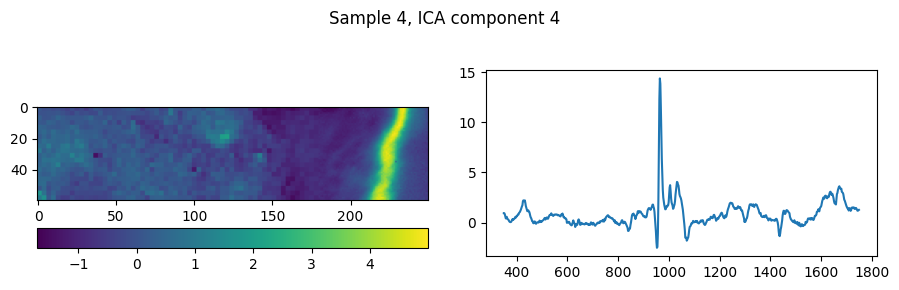

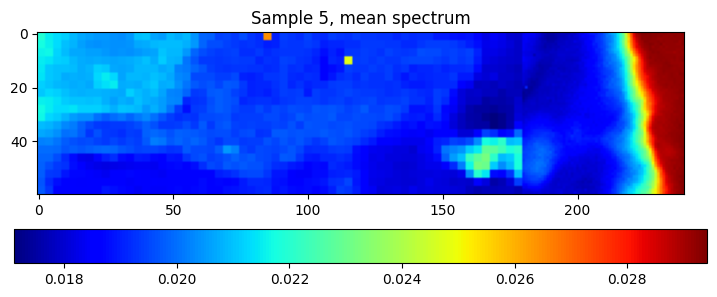

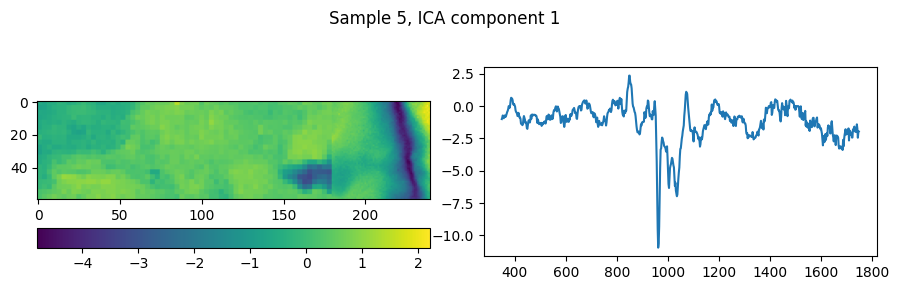

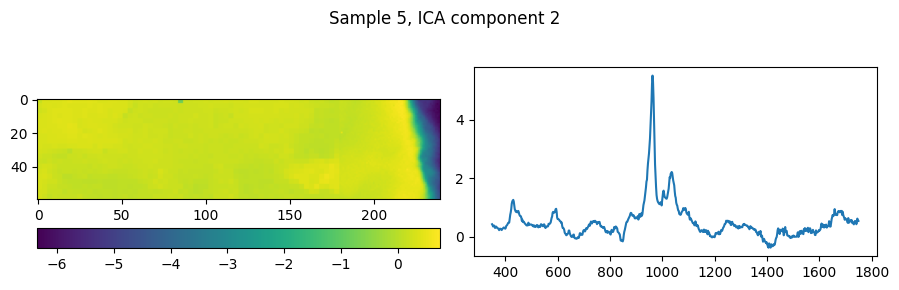

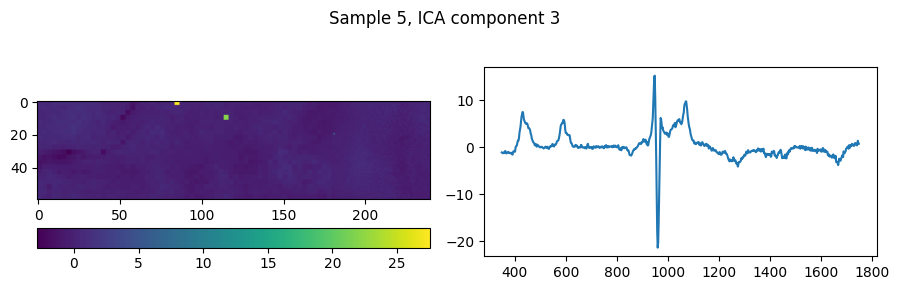

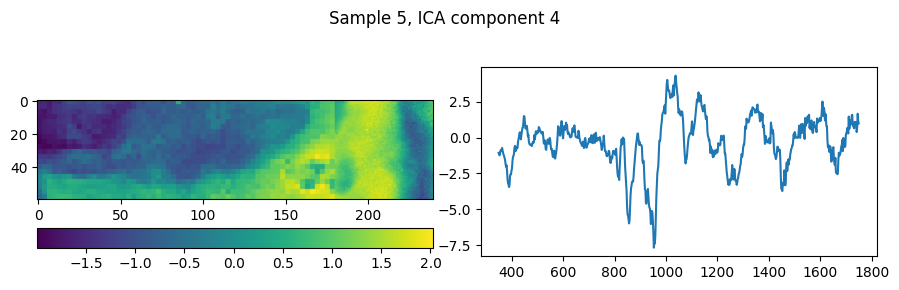

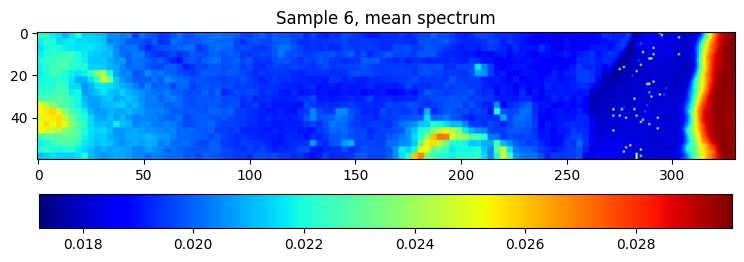

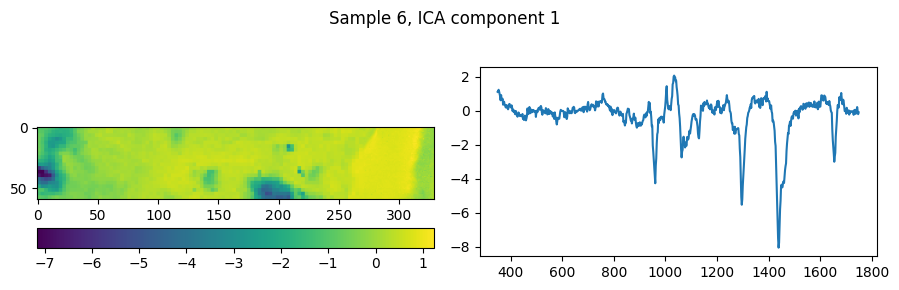

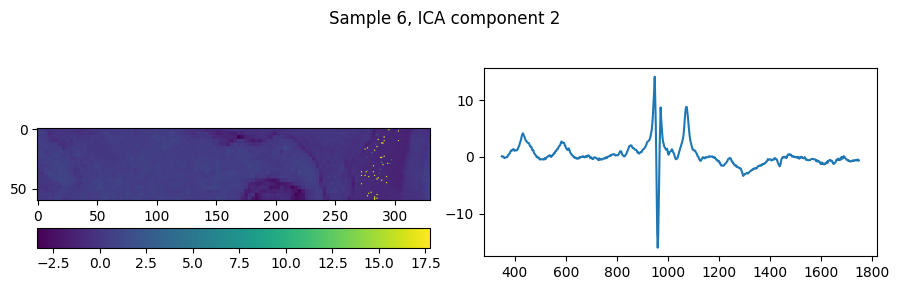

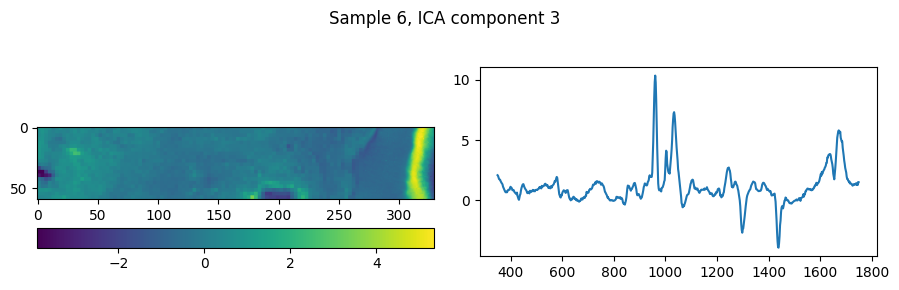

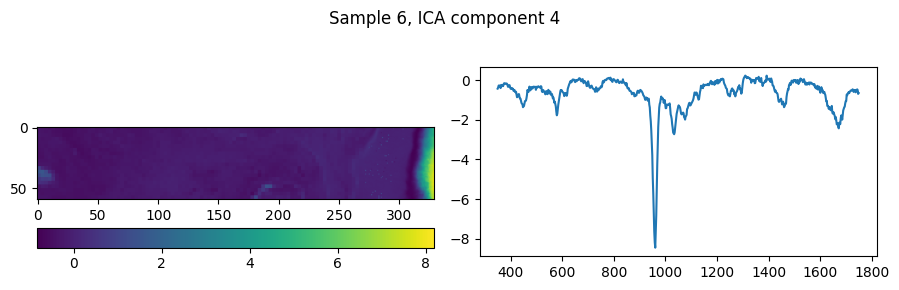

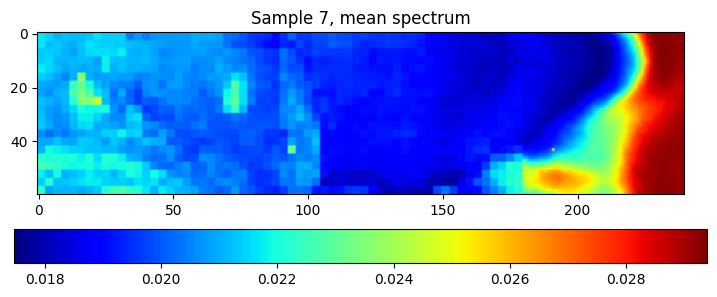

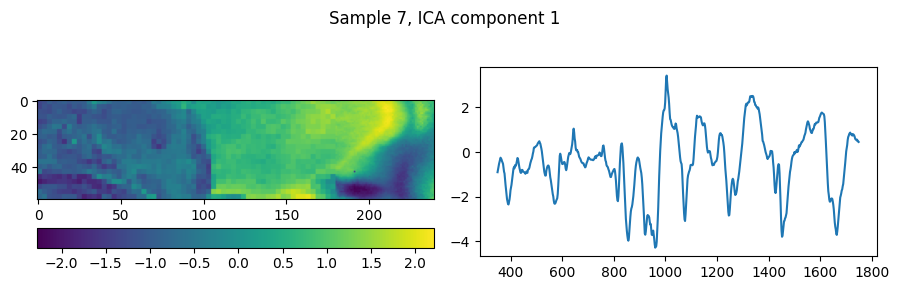

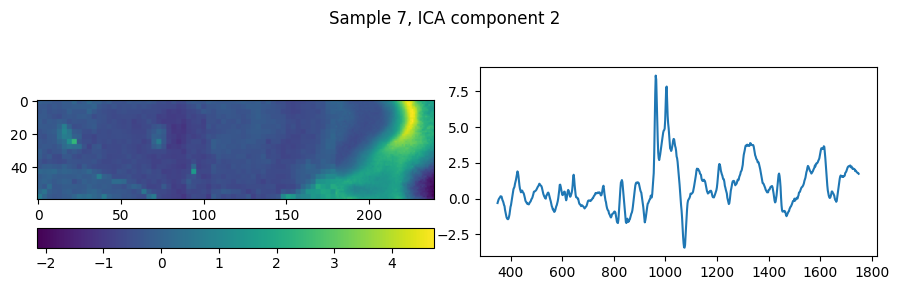

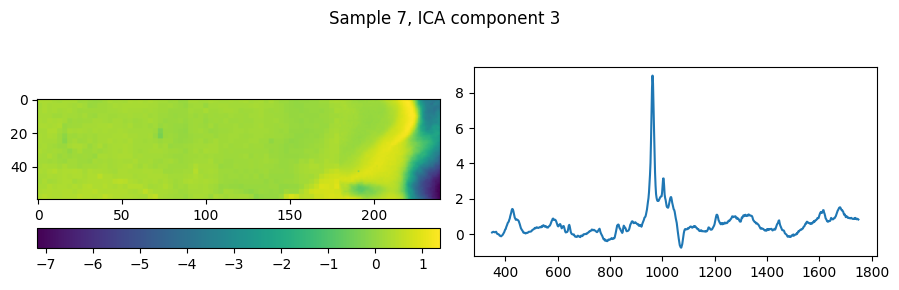

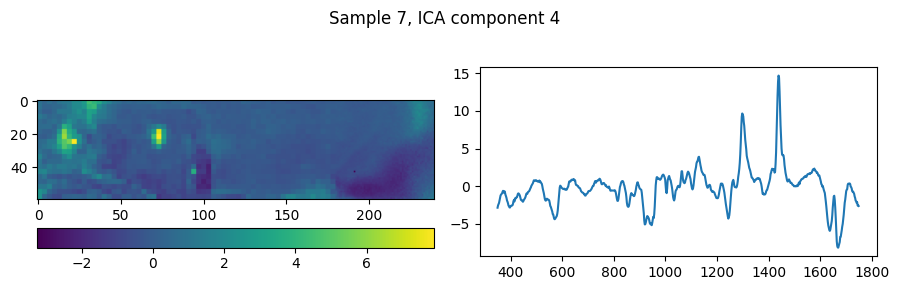

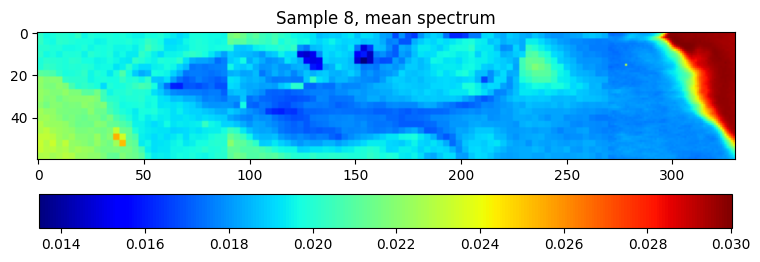

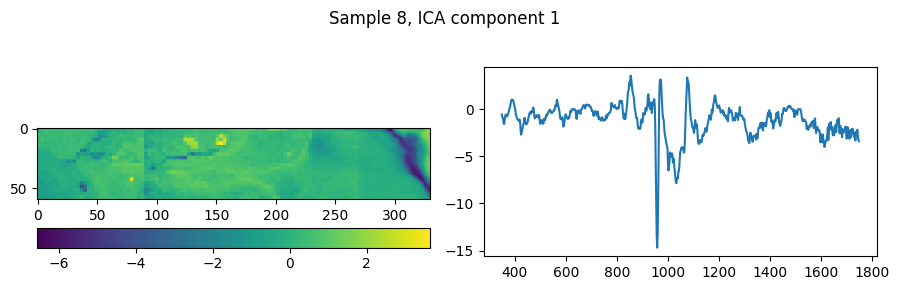

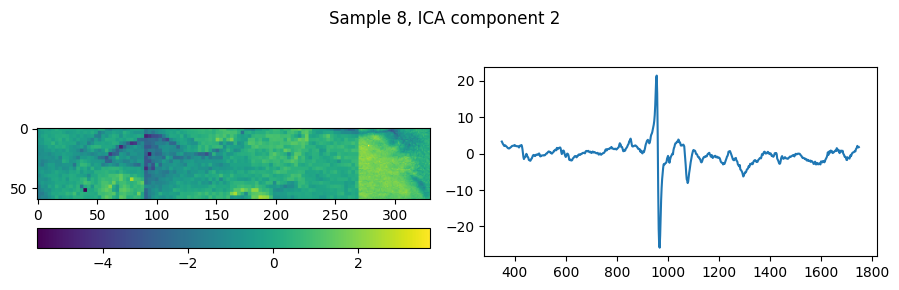

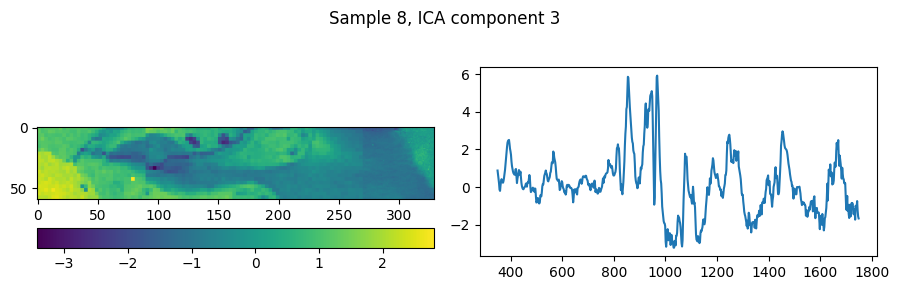

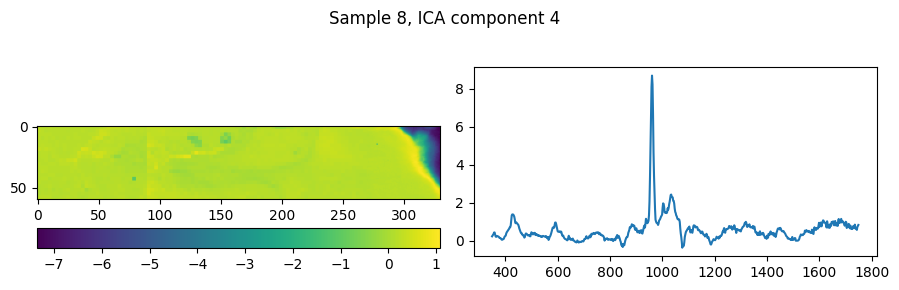

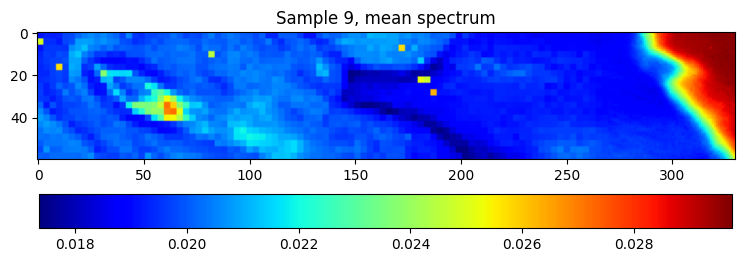

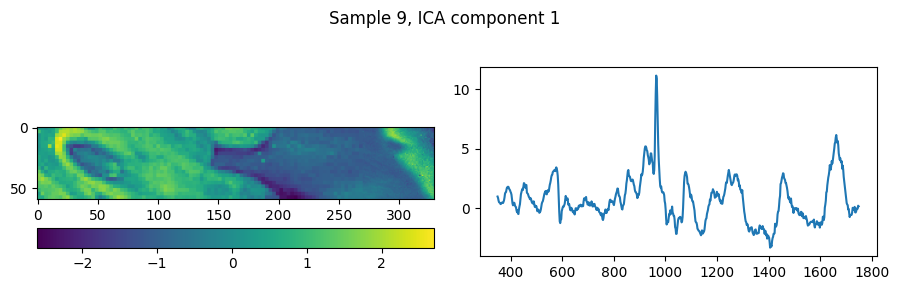

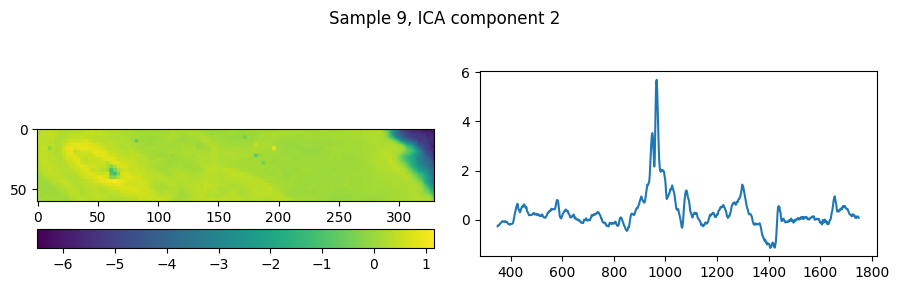

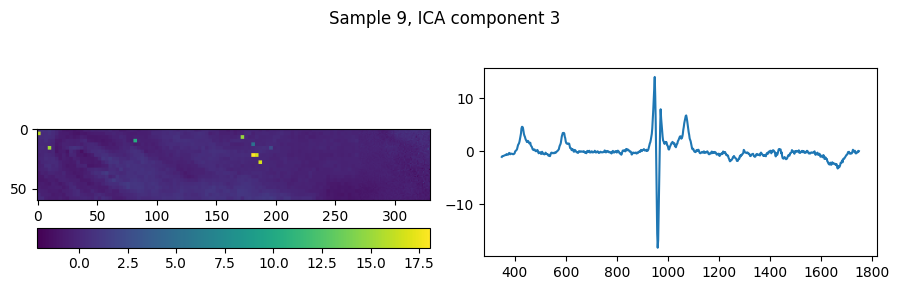

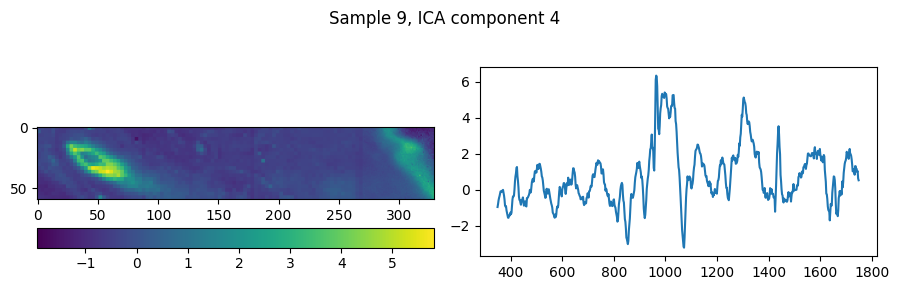

In [25]:
# ICA
components = 4
ica = FastICA(n_components=components)

for sample_id in range(len(data)):
    # Move wavenumber dimension as last
    sample = np.transpose(data[sample_id], (1, 2, 0))
    dim = sample.shape

    # Calculate ICA and predict on the image
    sample_clustered = ica.fit_transform(sample.reshape(dim[0] * dim[1], -1))

    # Return original shape
    sample_clustered = sample_clustered.reshape(dim[0], dim[1], -1)

    # Show results
    # Mean spectrum
    plt.imshow(np.mean(data[sample_id], axis=0), cmap='jet')
    plt.title(f'Sample {sample_id}, mean spectrum')
    plt.colorbar(orientation='horizontal')
    plt.show()

    

    # Clustering
    for c in range(components):
        # Show the distribution of the independent component
        plt.rcParams["figure.figsize"] = (9,3)
        plt.subplot(121)
        plt.imshow(sample_clustered[:, :, c])
        plt.suptitle(f'Sample {sample_id}, ICA component {c+1}')
        plt.colorbar(orientation='horizontal')

        # Show spectrum for the independent component
        plt.subplot(122)
        plt.plot(wavenumber[sample_id], ica.components_[c])
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

ICA seems to also cluster the tissues nicely. For example, a thin layer of calcified cartilage is likely seen on sample 1, component 4.

# Conclusion

**Probable main reasons for overfitting the OARSI grade prediction**:
- Too little training data. Only 5 samples for training and validation
- Too vague target. All pixels were labeled based on the sample grade. A better alternative would be to grade each sample individually, but this would require a larger dataset (now we had only 5 training samples). **Convolutional neural networks would be ideal for this task**.

After finishing the tutorial, you should know the basics for predicting continuous/ordinal variables (**regression**), importance of **avoiding overfitting**, and how to utilize the most common **unsupervised technhiques** (clustering, component analysis).

Main limitations of the experiment:
- Small amount of samples, training and validation include same samples
- Ordinal variable assumed continuous
- Single label assigned to each sample. Regional differences likely exist within one sample.

One possibility to improve the results would be including a **feature extraction** step (e.g. integrate over pathologically important peaks, peak ratios, spectral features). This technique was used in tutorial 3 for image data, and will also be useful in the last tutorial.